# Model Churn Telco

The following tools will be used throughout the project.

Catboost
Streamlit
FastAPI
Docker
Table of Contents
- 1. Aim of the Project and Data Set 
-- Data Set
- 2. Data Preprocessing and Model Development
- 3. Interface (Streamlit)
<!-- - 4. API (FastAPI) -->
<!-- - 5. Automation (Docker) -->

https://miro.medium.com/v2/resize:fit:720/format:webp/1*2se448p2nO8Sqcwq_KzrTA.png

You can access the customer data to be used in the project from Kaggle. This dataset consists of 7043 customers with 21 columns (features). It contains customer account information, demographic information, and registered services. The target variable (Churn) provides information on whether the customer has churned.
The dataset is available at the following link: https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113

# Library

In [1]:
# @title Install Modules
# !pip install numpy pandas matplotlib tensorflow torch catboost scikit-learn shap streamlit sweetviz
# !pip install pandas==1.3.5

In [1]:
# @title Import Modules and Libraries 
# Data
import numpy as np
import pandas as pd
import os
# import sys
# sys.path.append('../')

# Machine learning
import sklearn
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import (
    accuracy_score, classification_report, recall_score, confusion_matrix,
    roc_auc_score, precision_score, f1_score, roc_curve, auc
)
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostClassifier, Pool

# Visualization
import shap
from matplotlib import pyplot as plt
import seaborn as sns
from pyarrow import parquet as pq
import joblib
import pyarrow as pa
import streamlit as st
import sweetviz as sv


In [3]:
os.listdir()

['END-To-END Machine Learning.ipynb']

# Data Set

There are many categorical variables in the dataset. By encoding them numerically, we can use different models with various preprocessing techniques. In this study, we will focus on using the proven Catboost algorithm for handling categorical variables. To enhance model development performance, consider using tools like Optuna for hyperparameter optimization.

In [4]:
# @title Load
data_path = '../../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(data_path, low_memory=True)

In [6]:
# @title Preprocessing 

# Convert TotalCharges to numeric, filling NaN values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['tenure'] * df['MonthlyCharges'], inplace=True)

# Convert SeniorCitizen to object
df['SeniorCitizen'] = df['SeniorCitizen'].astype(object)

# Replace 'No phone service' and 'No internet service' with 'No' for certain columns
df['MultipleLines'] = df['MultipleLines'].replace('No phone service', 'No')
columns_to_replace = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for column in columns_to_replace:
    df[column] = df[column].replace('No internet service', 'No')

# Convert 'Churn' categorical variable to numeric
df['Churn'] = df['Churn'].replace({'No': 0, 'Yes': 1})
df_ = df.copy()

C:\Users\frany\AppData\Local\Temp\ipykernel_25848\2100822667.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['tenure'] * df['MonthlyCharges'], inplace=True)
C:\Users\frany\AppData\Local\Temp\ipykernel_25848\2100822667.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)

## StratifiedShuffleSplit Samples

In [11]:
import pickle
# Create the StratifiedShuffleSplit object
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=64)

train_index, test_index = next(strat_split.split(df_, df_["Churn"]))

# Create train and test sets
strat_train_set = df.loc[train_index]
strat_test_set = df.loc[test_index]

X_train = strat_train_set.drop("Churn", axis=1)
y_train = strat_train_set["Churn"].copy()

X_test = strat_test_set.drop("Churn", axis=1)
y_test = strat_test_set["Churn"].copy()

# Guardar el objeto en un archivo pickle
with open('../../data/process/X_train.pkl', 'wb') as file:
    pickle.dump(X_train, file)

with open('../../data/process/y_train.pkl', 'wb') as file:
    pickle.dump(y_train, file)

with open('../../data/process/X_test.pkl', 'wb') as file:
    pickle.dump(X_test, file)

with open('../../data/process/y_test.pkl', 'wb') as file:
    pickle.dump(y_test, file)

In [9]:
# Inform HTML with report sweetviz
my_report = sv.analyze([df, "Database"], target_feat='Churn')

# Definir la ruta donde se guardará el archivo HTML
output_path = '../../src/report/my_report.html'

# Crear el directorio si no existe
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Mostrar y guardar el reporte en HTML en la ruta especificada
my_report.show_html(filepath=output_path)

                                             |          | [  0%]   00:00 -> (? left)

Report ../../src/report/my_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



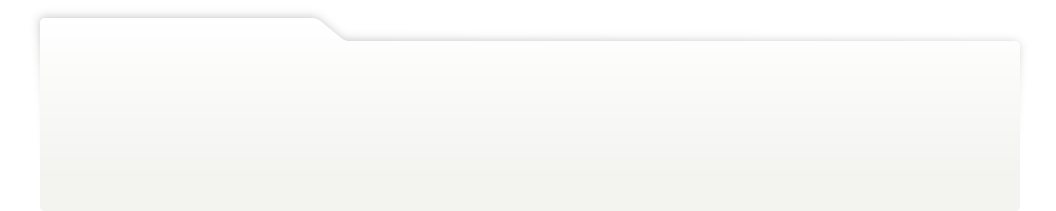
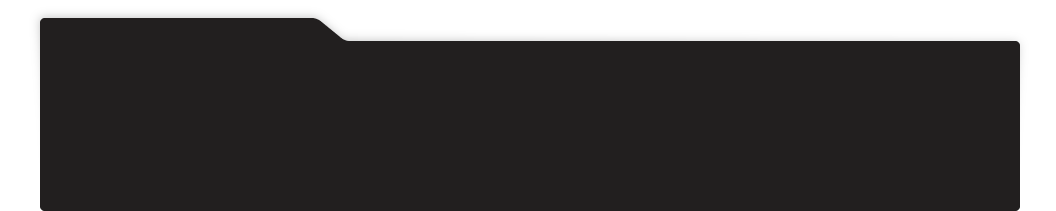
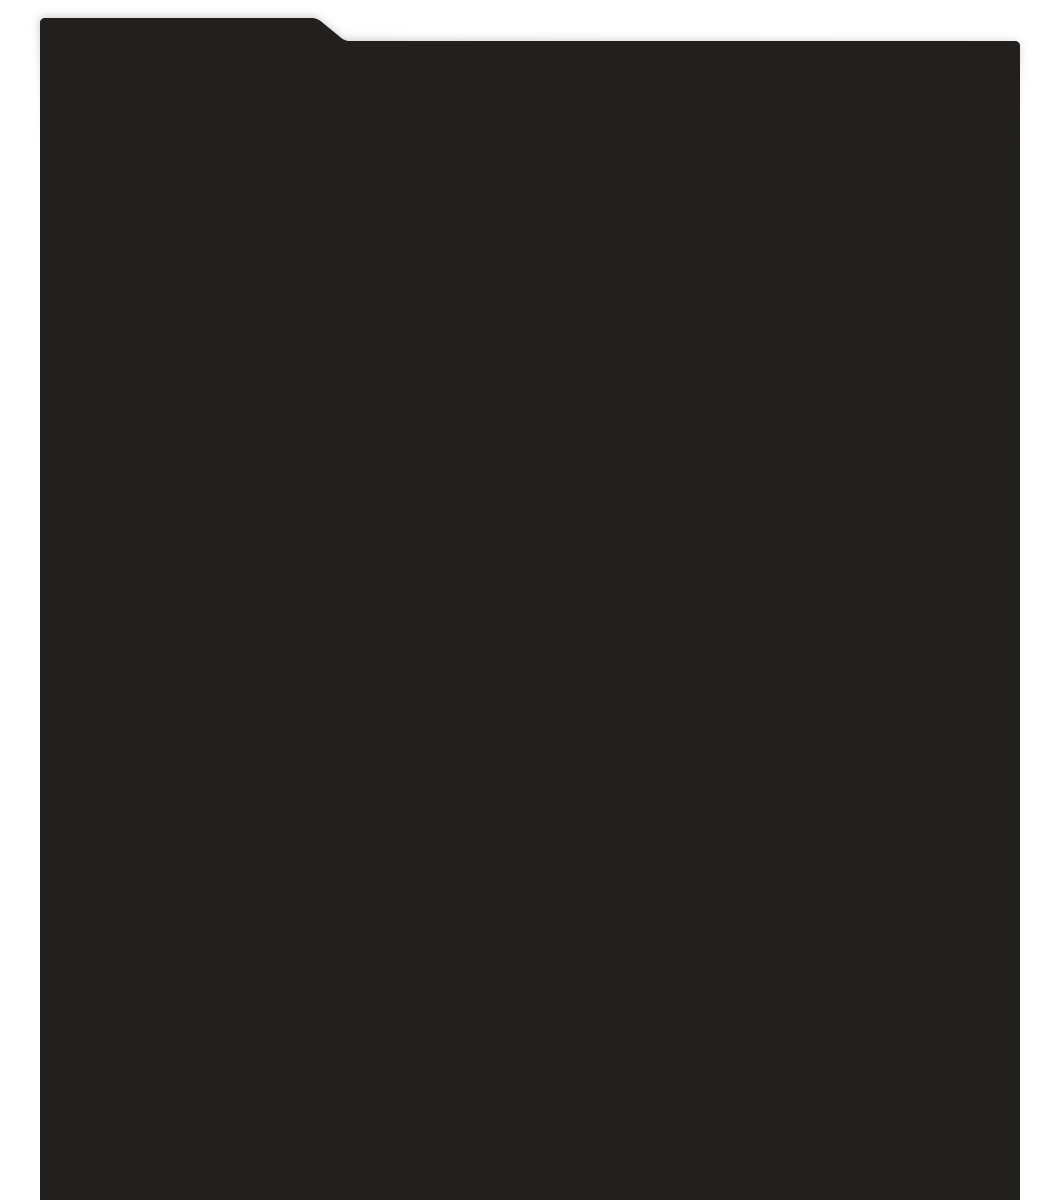
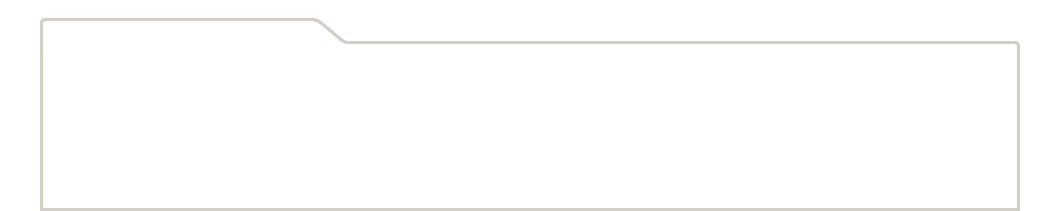
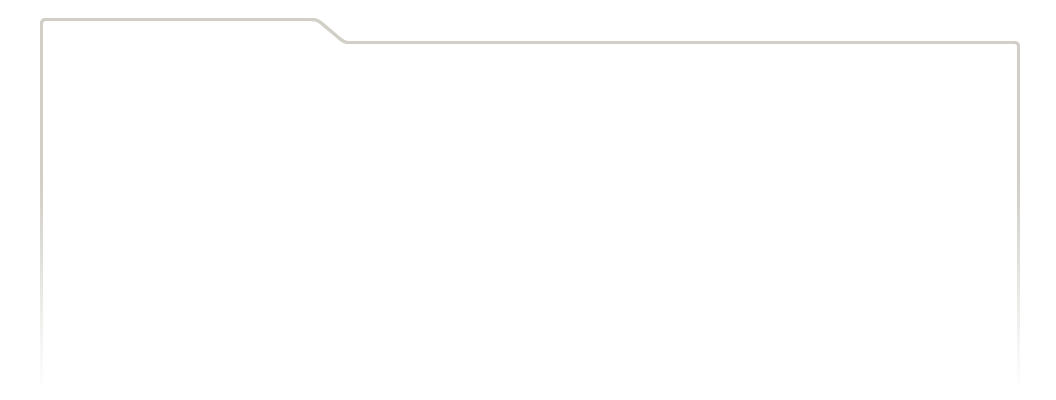
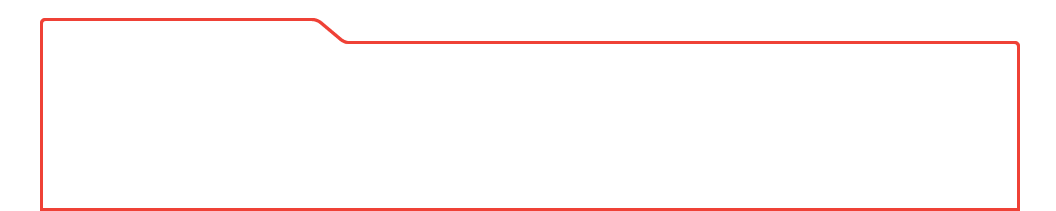
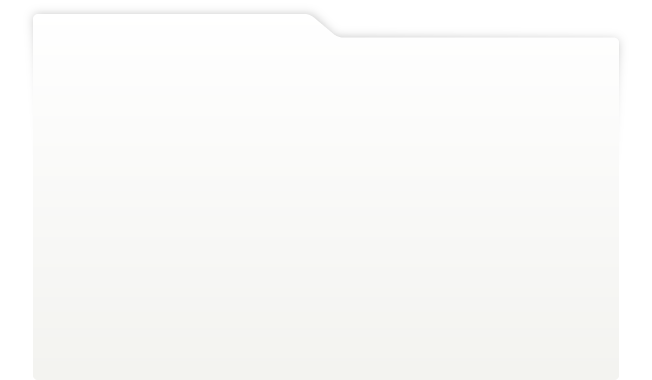
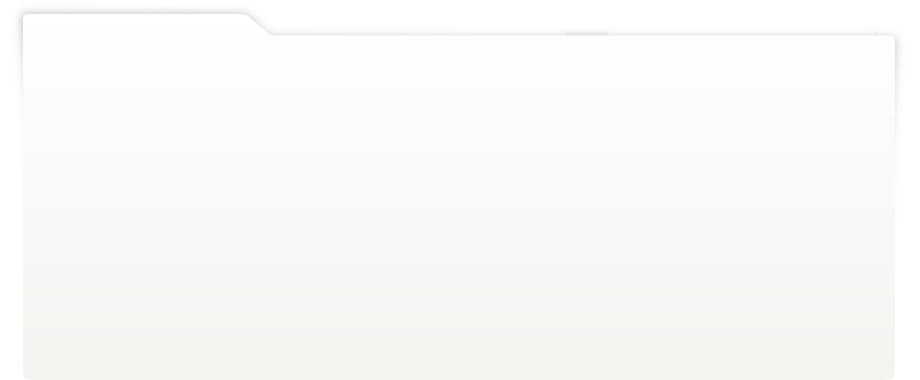
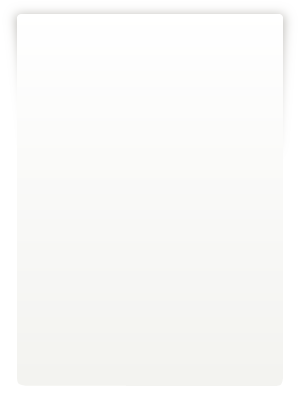
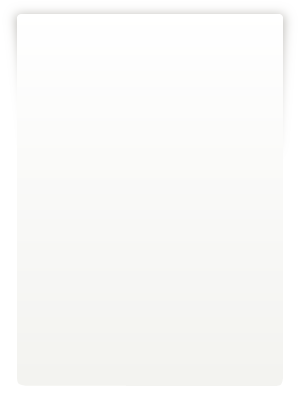
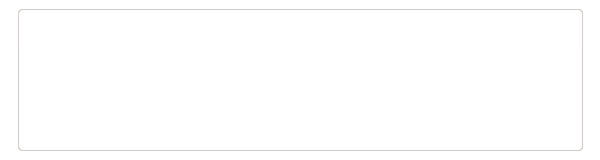
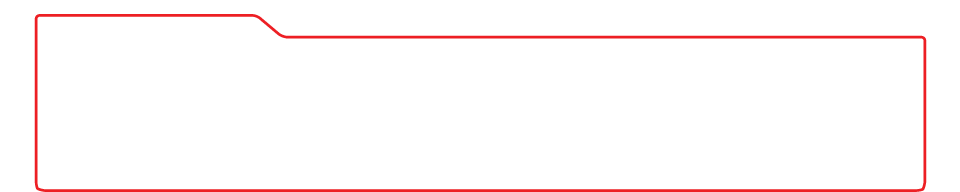
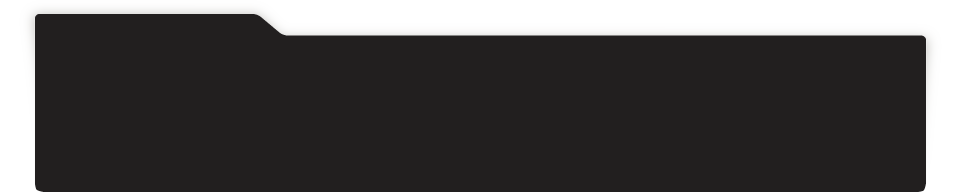
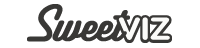
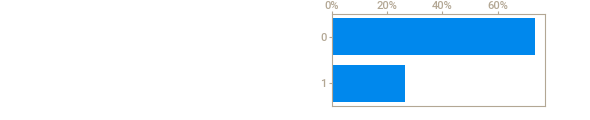
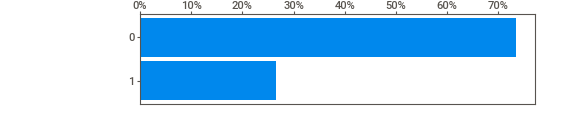
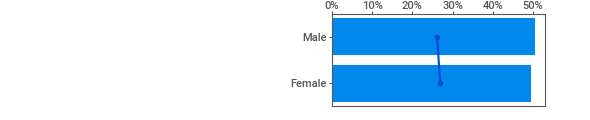
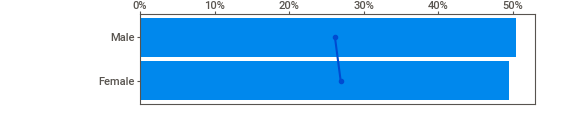
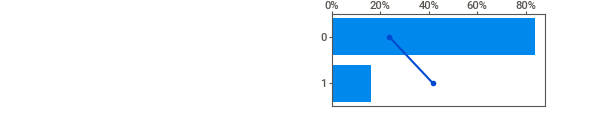
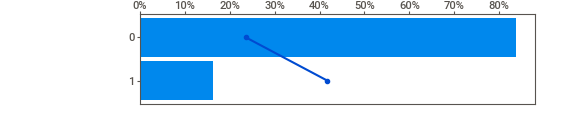
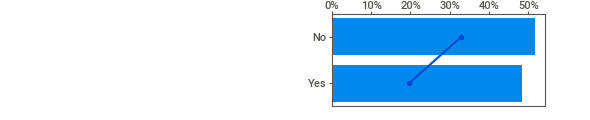
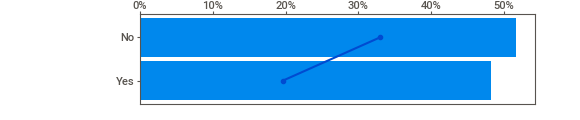
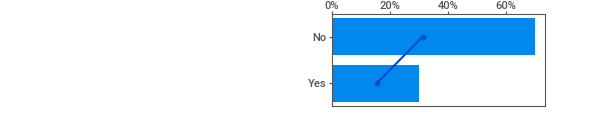
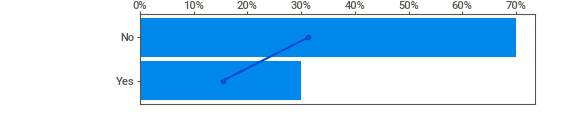
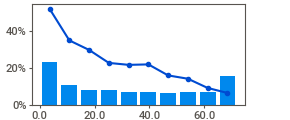
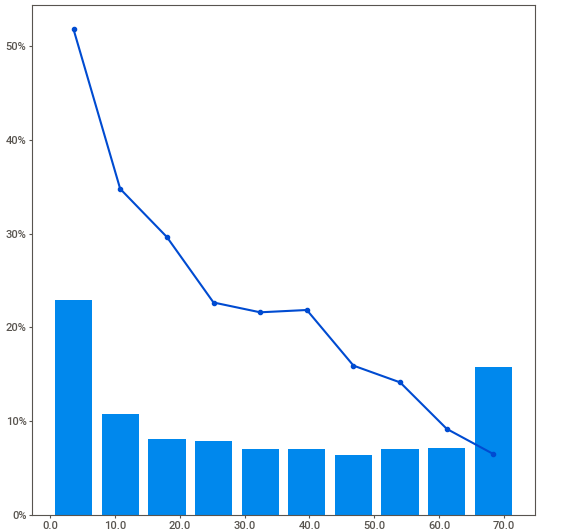
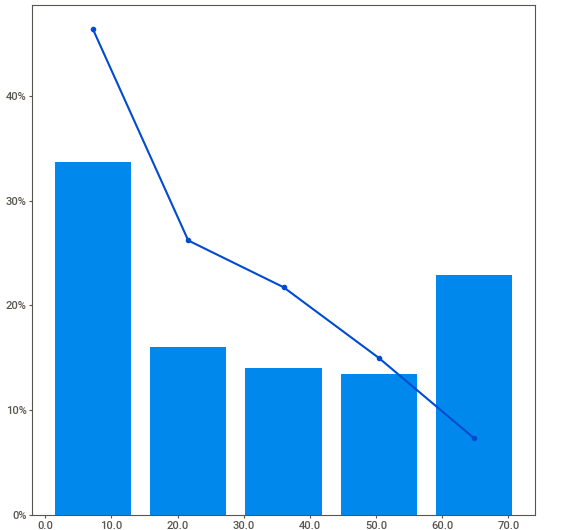
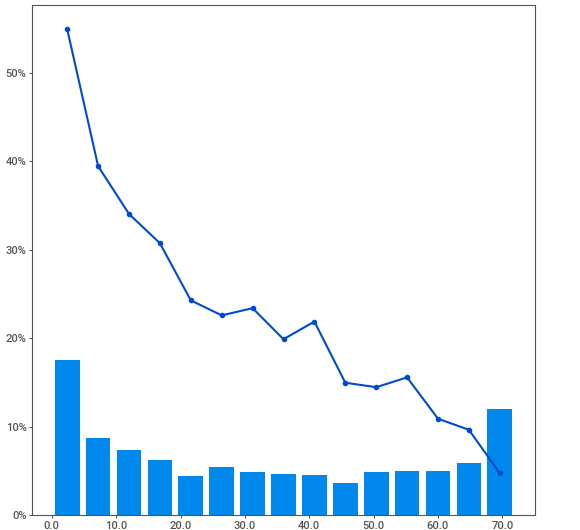
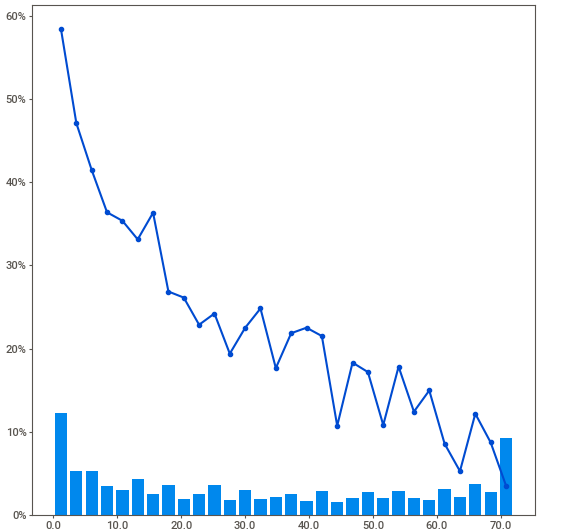
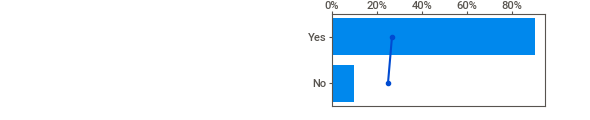
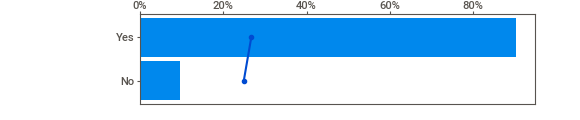
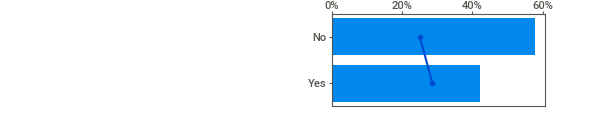
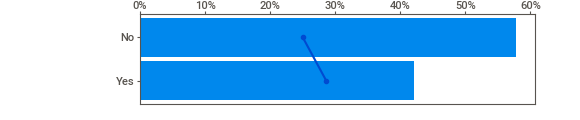
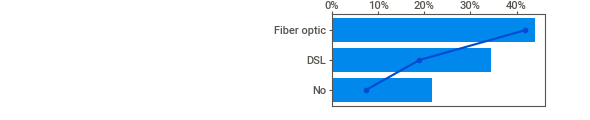
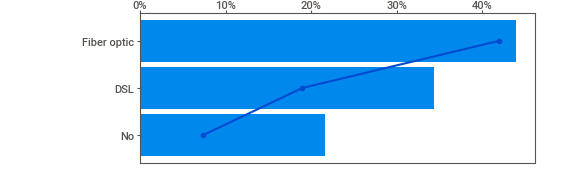
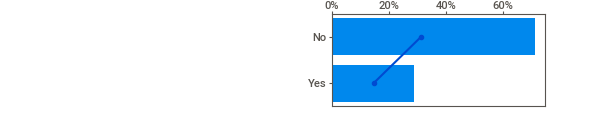
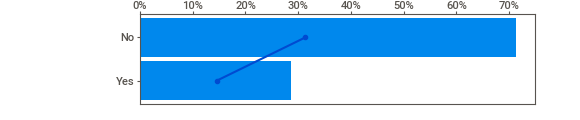
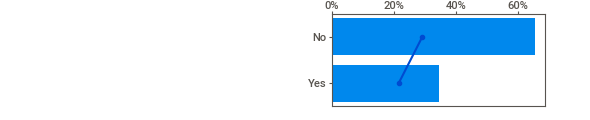
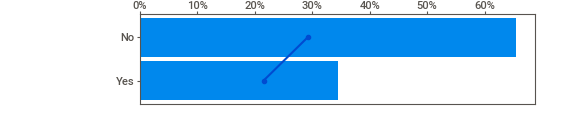
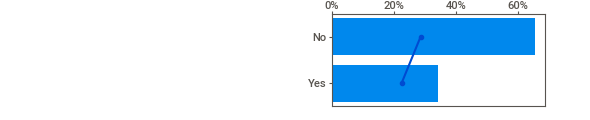
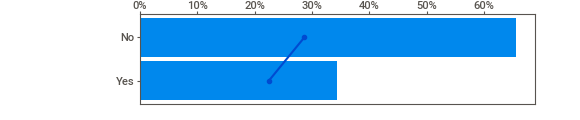
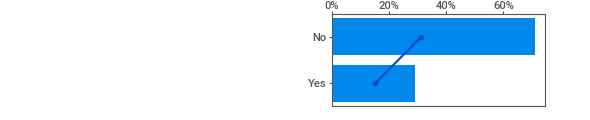
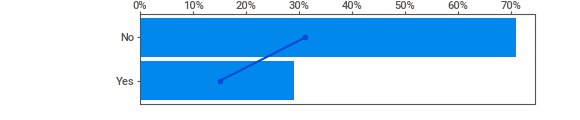
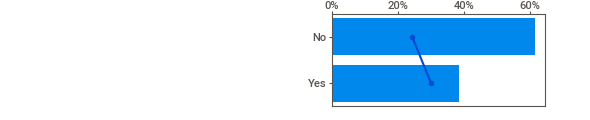
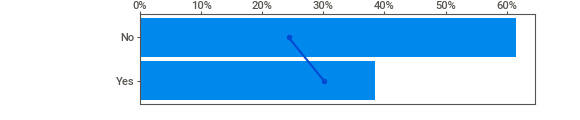
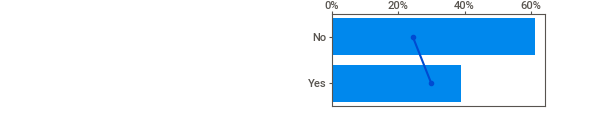
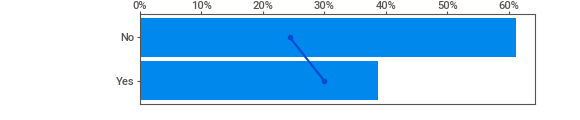
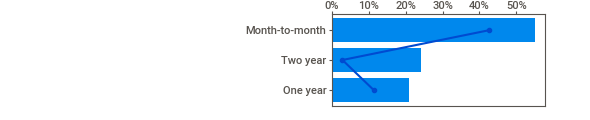
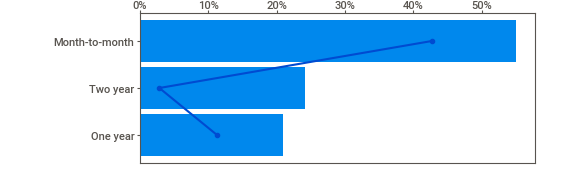
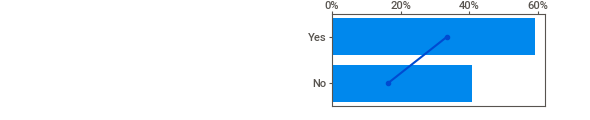
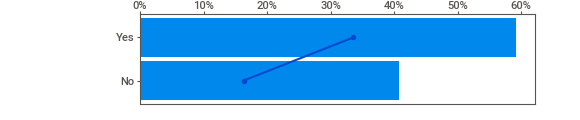
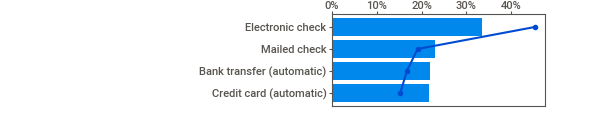
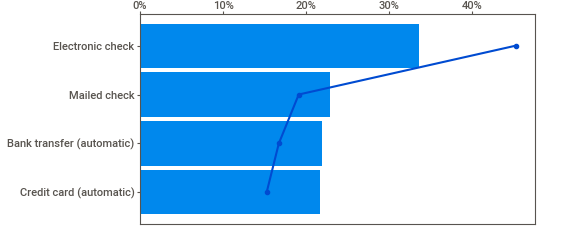
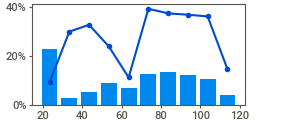
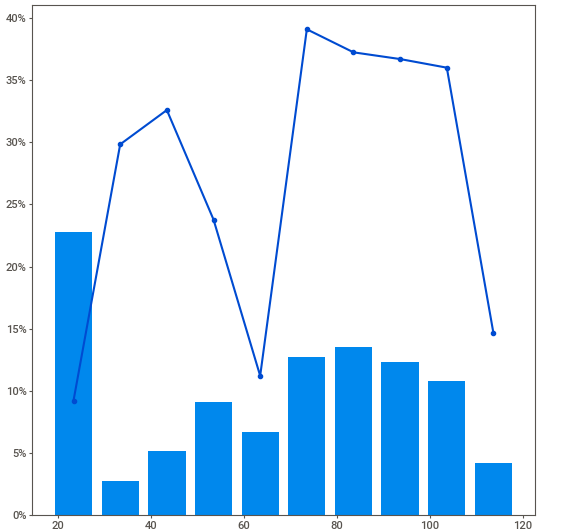
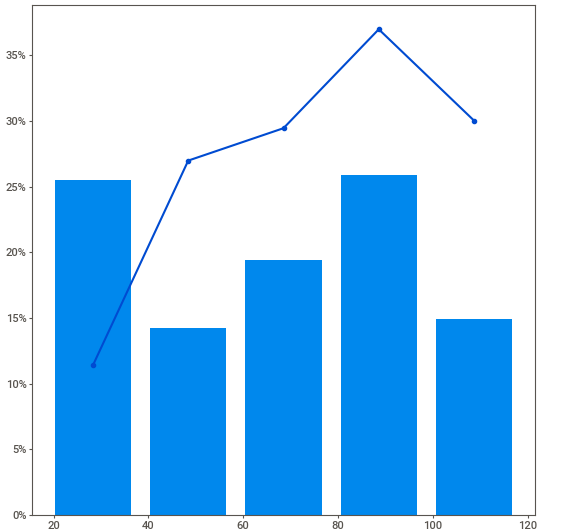
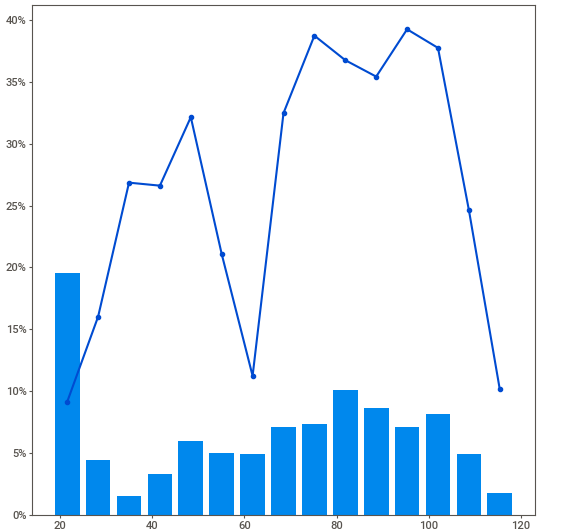
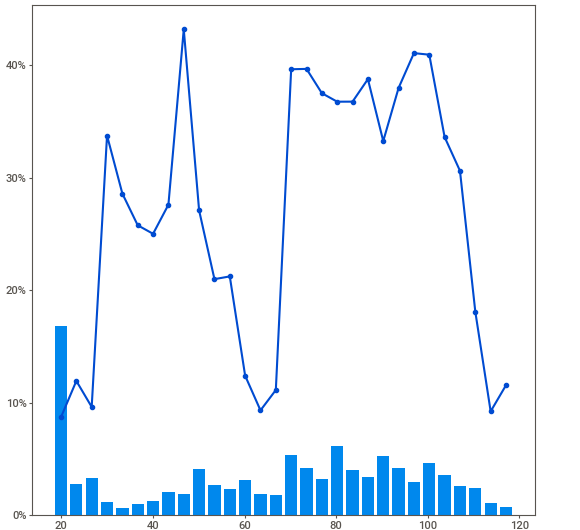
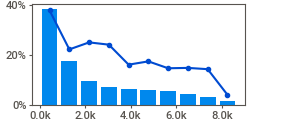
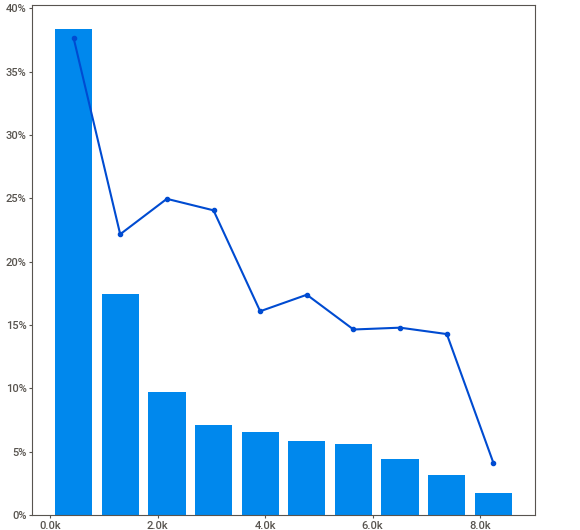
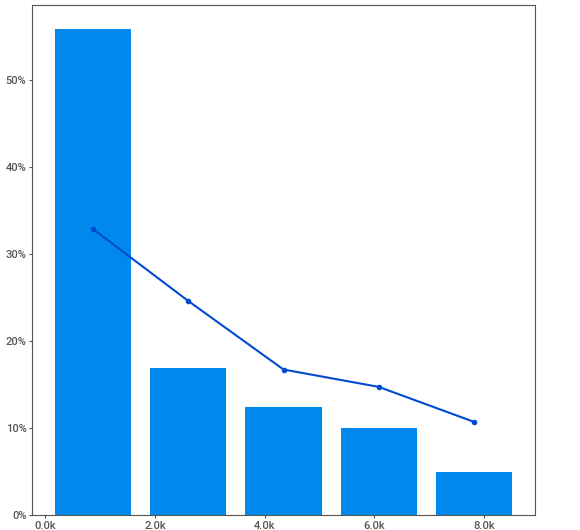
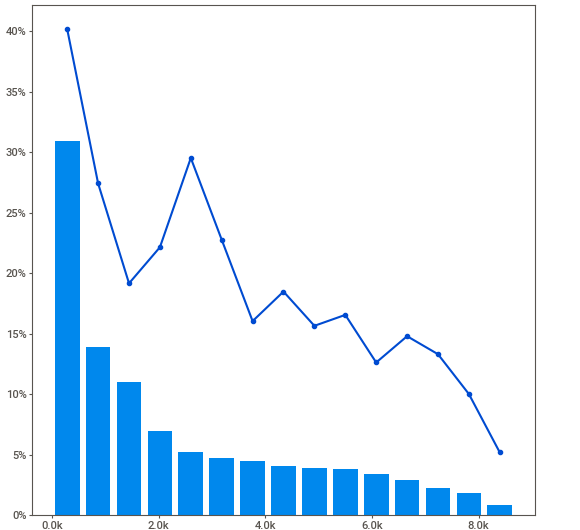
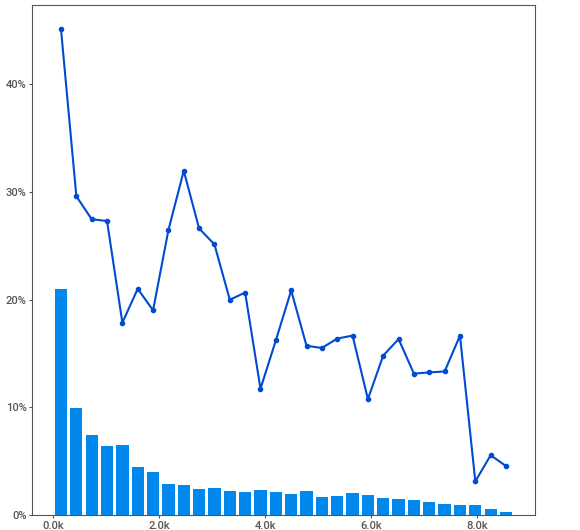
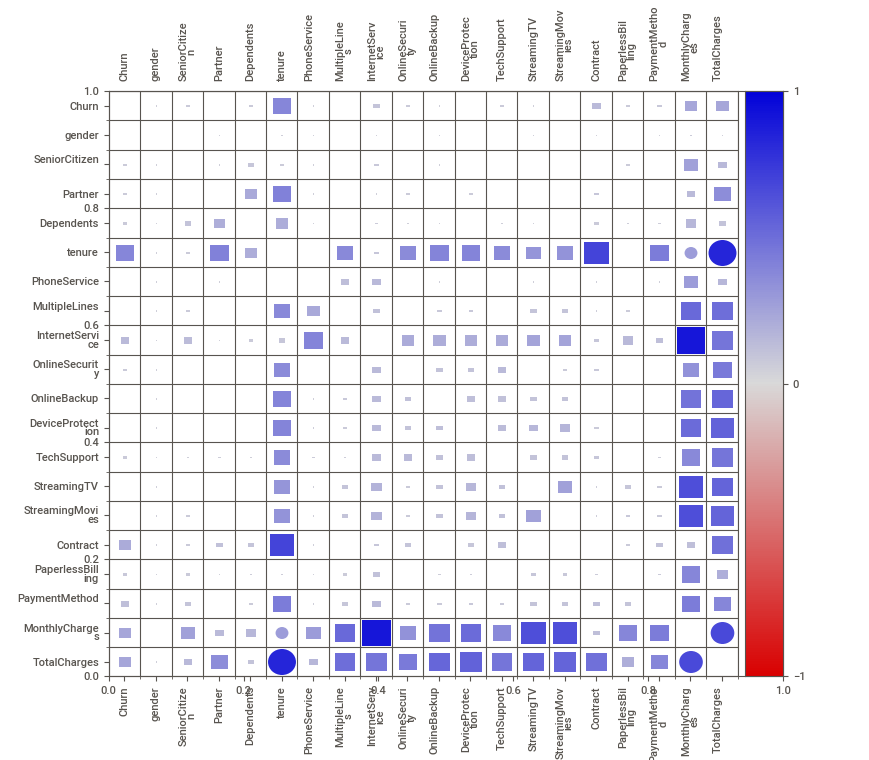
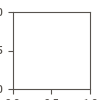

In [10]:
my_report.show_notebook()

In [12]:
df.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0


In [13]:
# Composition
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [14]:
df.shape

(7043, 21)

In [15]:
# @title Data
def grab_col_names(dataframe, cat_th=10, car_th=20):
    
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtype != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtype == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtype != "O" and col not in num_but_cat]
    
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat : {len(num_but_cat)}")
    print(f"cat_cols : {cat_cols}")
    print(f"num_cols : {num_cols}")
    print(f"cat_but_car : {cat_but_car}")
    
    return cat_cols, num_cols, cat_but_car

grab_col_names(df)

cat_cols, num_cols, cat_but_car = grab_col_names(df)
print("#############")
print(f"Cat_Cols : {cat_cols}")
print("#############")
print(f"Num_Cols : {num_cols}")
print("#############")
print(f"Cat_But_Car : {cat_but_car}")

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat : 1
cat_cols : ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
num_cols : ['tenure', 'MonthlyCharges', 'TotalCharges']
cat_but_car : ['customerID']
Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat : 1
cat_cols : ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
num_cols : ['tenure', 'MonthlyCharges', 'TotalCharges']
cat_but_car : ['customerID']
#############
Cat_Cols : ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'Mul

### Categoric Summary Function

        gender     Ratio
gender                  
Male      3555  50.47565
Female    3488  49.52435
##########################################


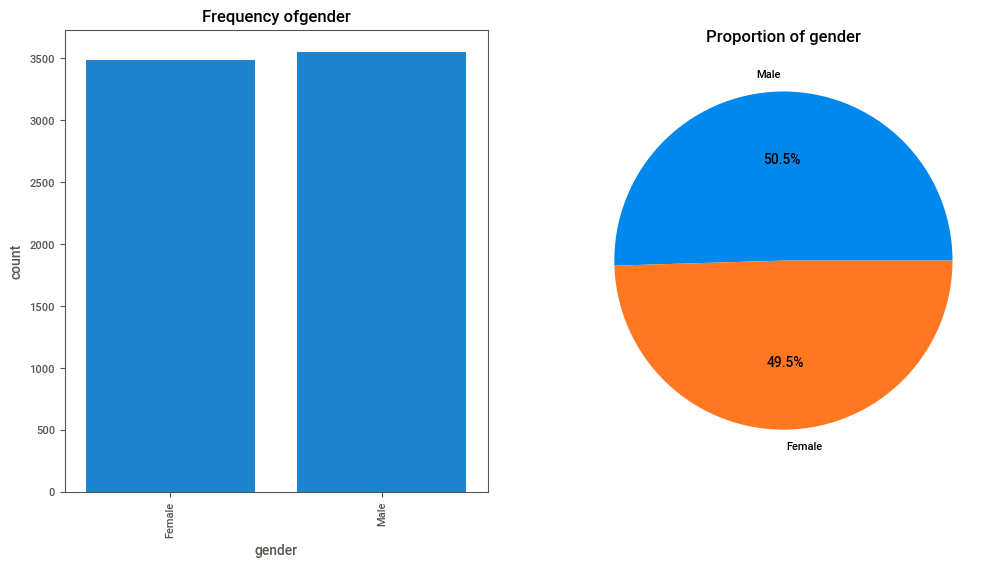

               SeniorCitizen      Ratio
SeniorCitizen                          
0                       5901  83.785319
1                       1142  16.214681
##########################################


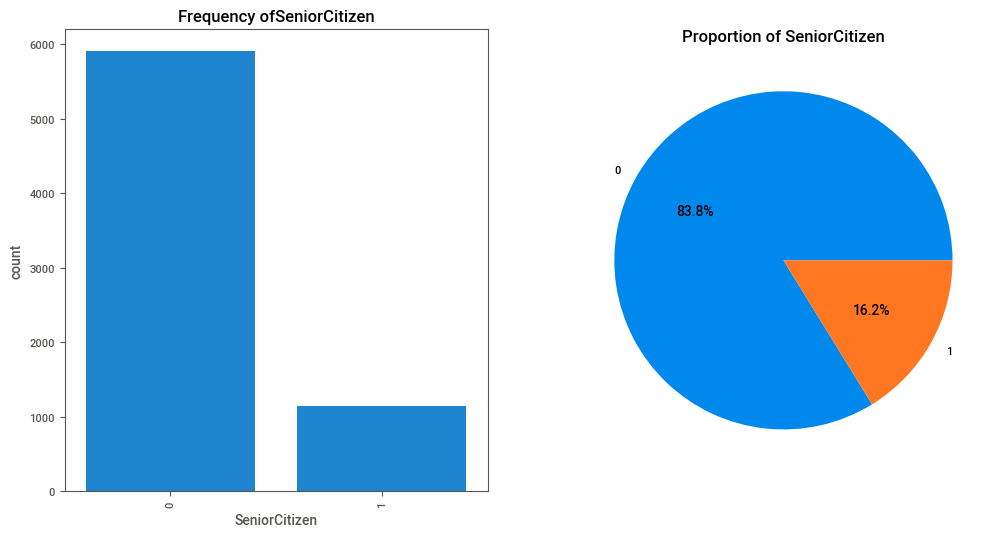

         Partner     Ratio
Partner                   
No          3641  51.69672
Yes         3402  48.30328
##########################################


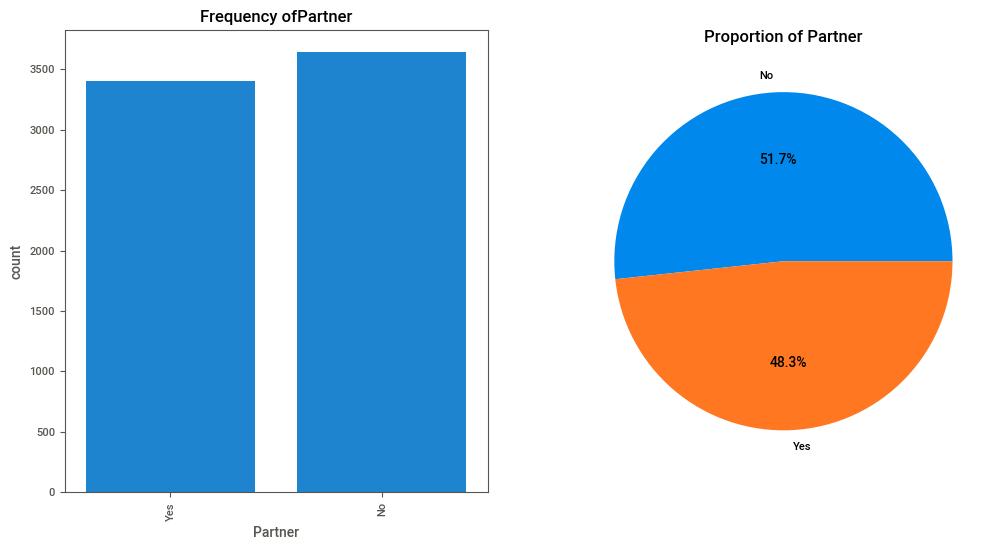

            Dependents      Ratio
Dependents                       
No                4933  70.041176
Yes               2110  29.958824
##########################################


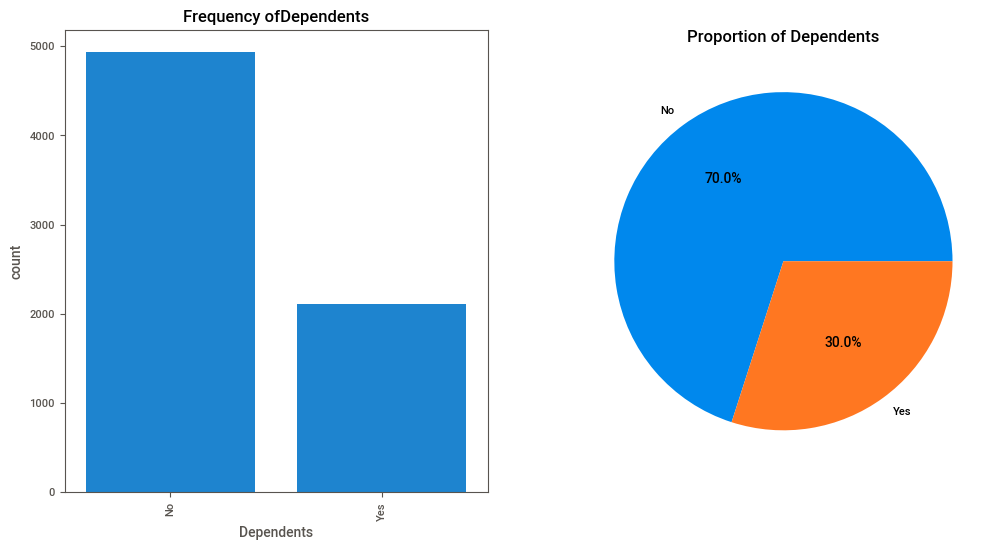

              PhoneService      Ratio
PhoneService                         
Yes                   6361  90.316626
No                     682   9.683374
##########################################


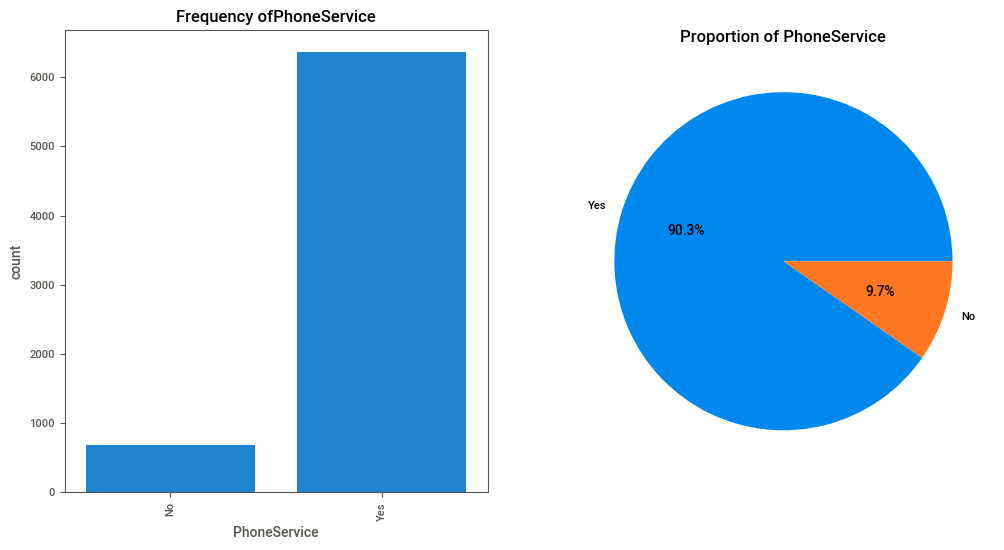

               MultipleLines      Ratio
MultipleLines                          
No                      4072  57.816271
Yes                     2971  42.183729
##########################################


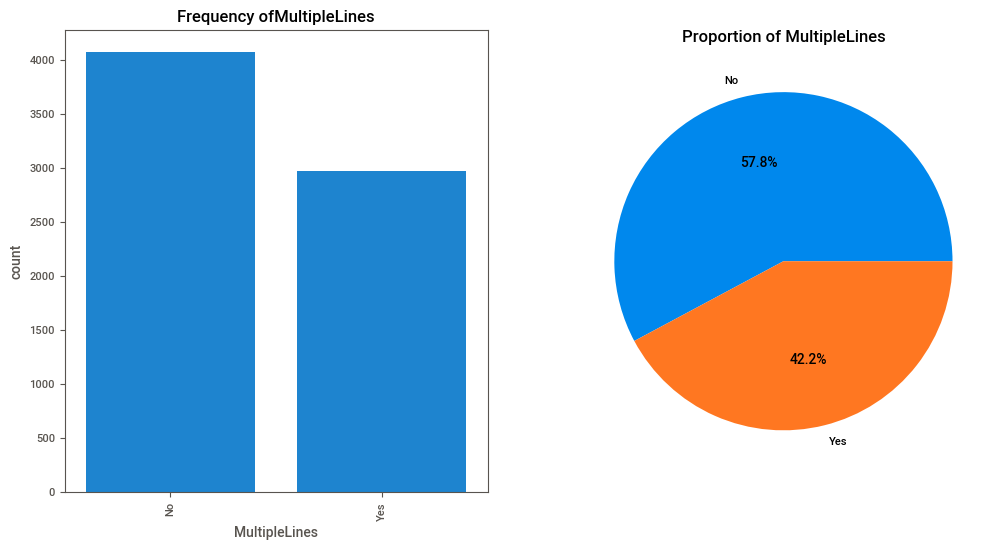

                 InternetService      Ratio
InternetService                            
Fiber optic                 3096  43.958540
DSL                         2421  34.374556
No                          1526  21.666903
##########################################


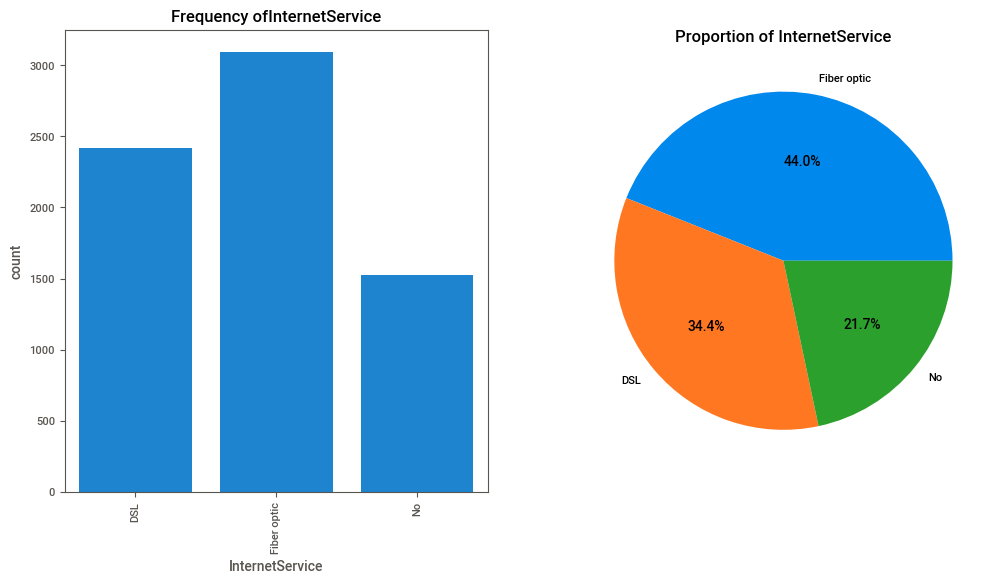

                OnlineSecurity      Ratio
OnlineSecurity                           
No                        5024  71.333239
Yes                       2019  28.666761
##########################################


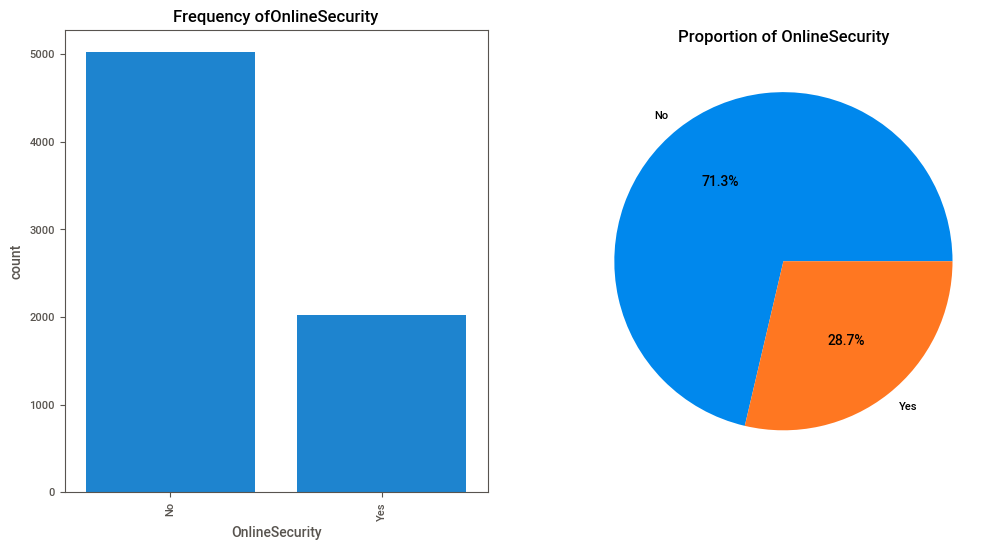

              OnlineBackup      Ratio
OnlineBackup                         
No                    4614  65.511856
Yes                   2429  34.488144
##########################################


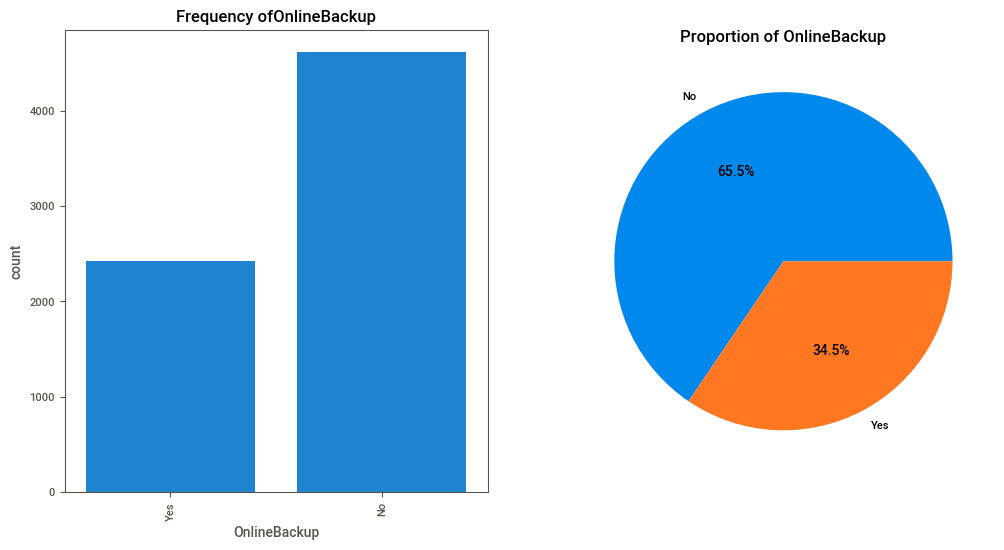

                  DeviceProtection      Ratio
DeviceProtection                             
No                            4621  65.611245
Yes                           2422  34.388755
##########################################


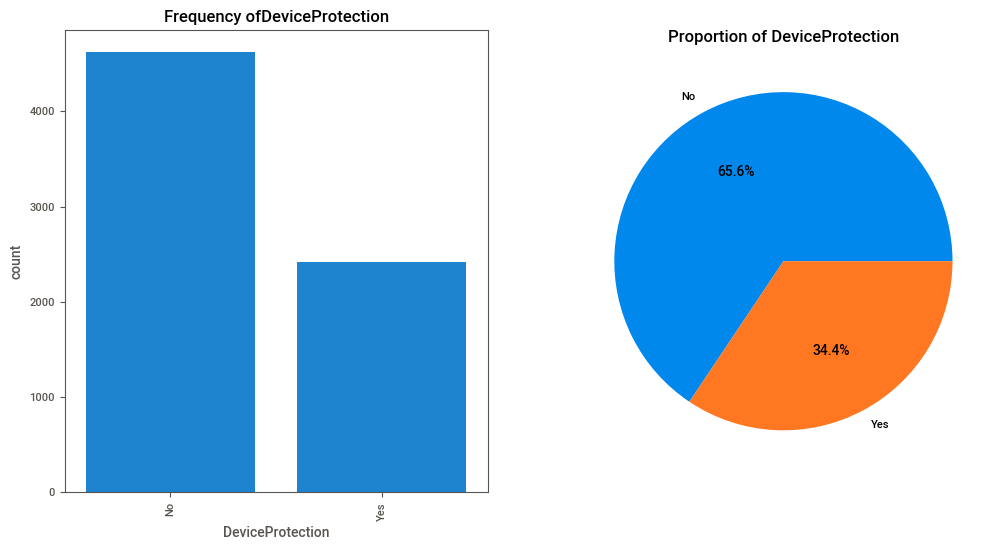

             TechSupport      Ratio
TechSupport                        
No                  4999  70.978276
Yes                 2044  29.021724
##########################################


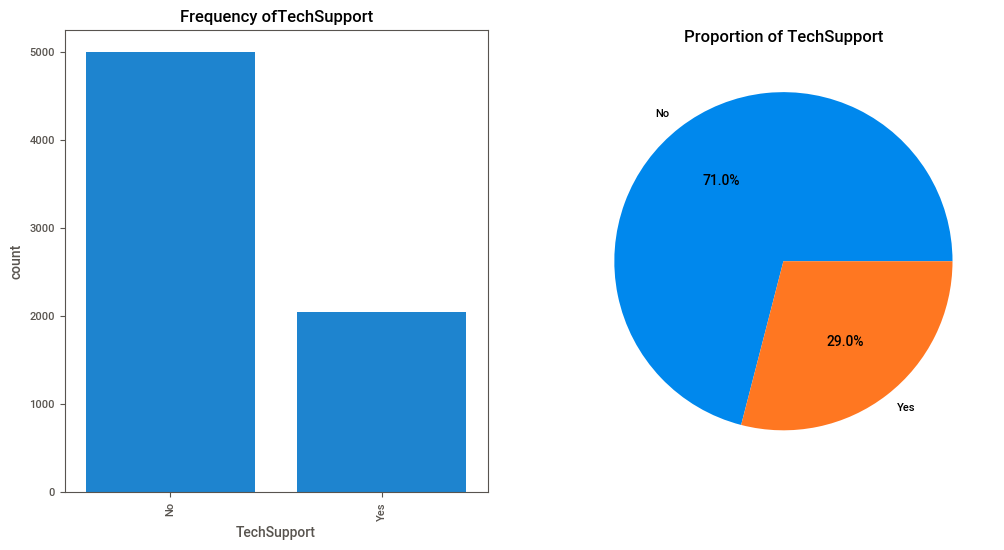

             StreamingTV      Ratio
StreamingTV                        
No                  4336  61.564674
Yes                 2707  38.435326
##########################################


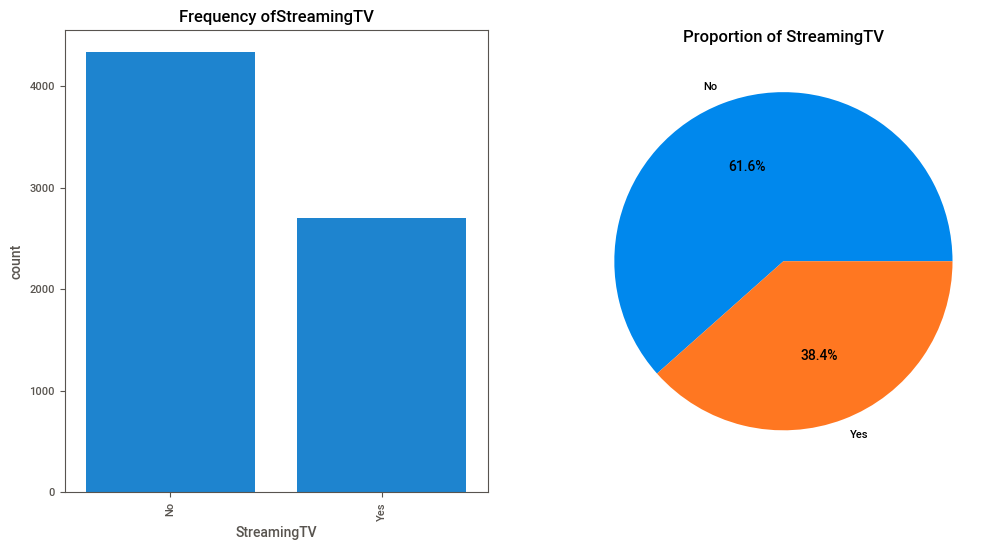

                 StreamingMovies      Ratio
StreamingMovies                            
No                          4311  61.209712
Yes                         2732  38.790288
##########################################


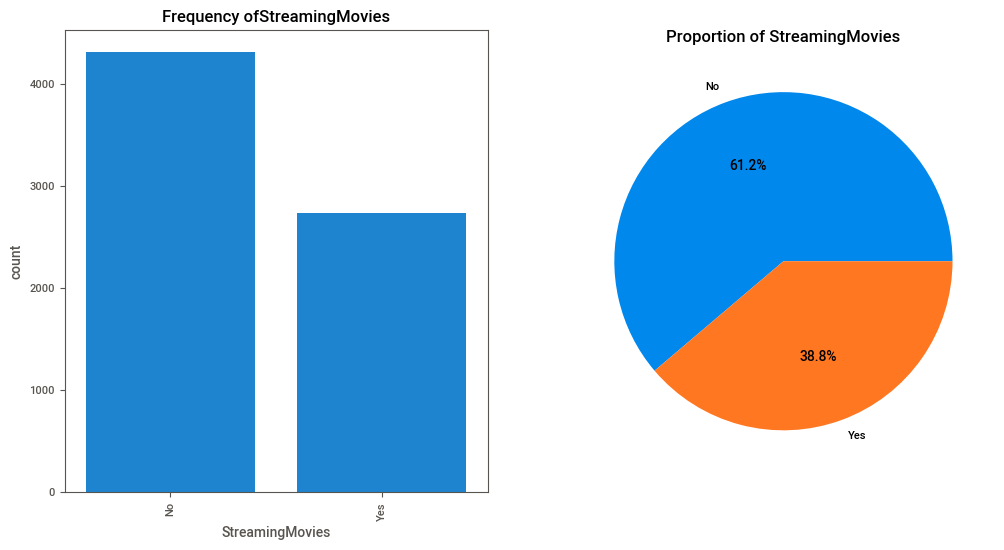

                Contract      Ratio
Contract                           
Month-to-month      3875  55.019168
Two year            1695  24.066449
One year            1473  20.914383
##########################################


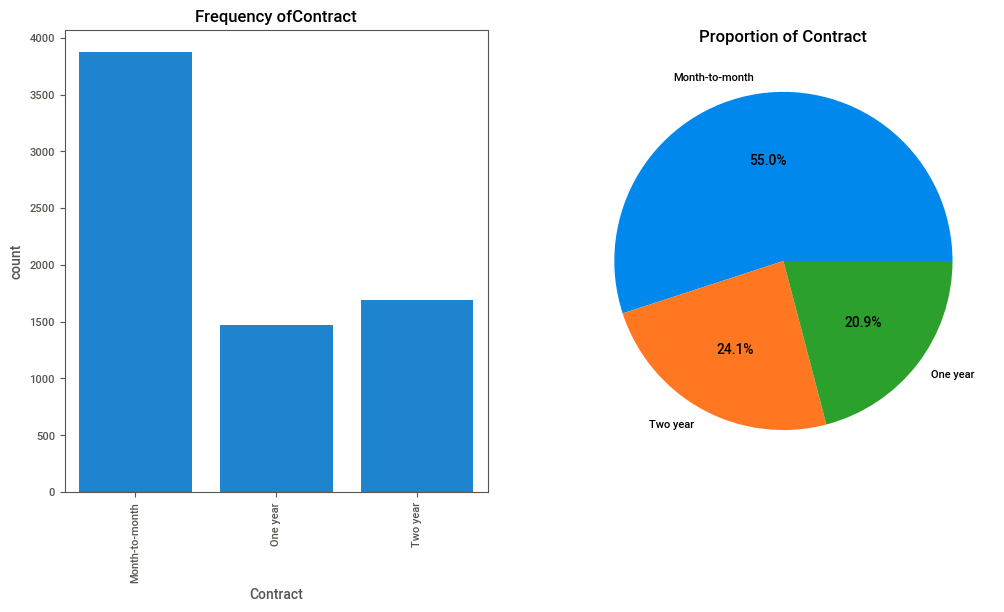

                  PaperlessBilling      Ratio
PaperlessBilling                             
Yes                           4171  59.221922
No                            2872  40.778078
##########################################


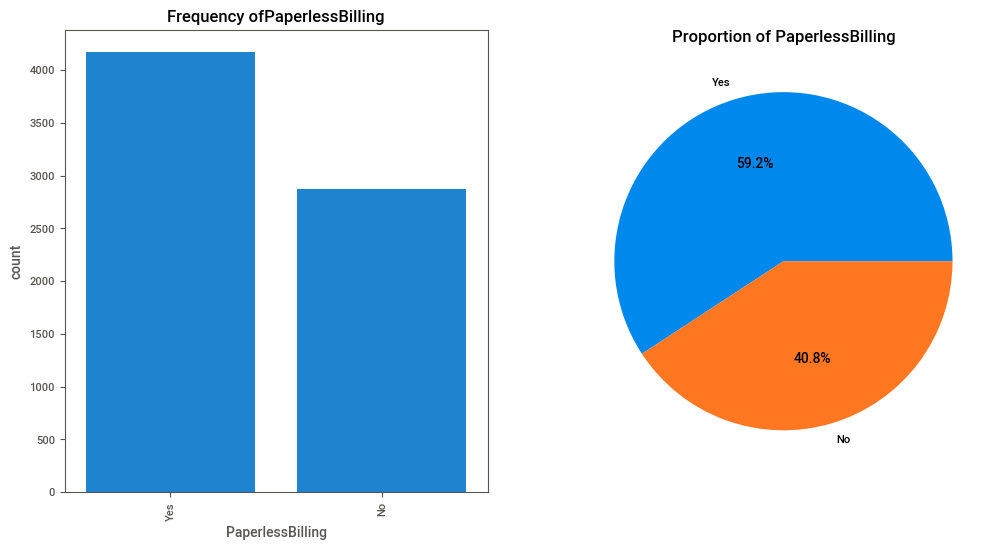

                           PaymentMethod      Ratio
PaymentMethod                                      
Electronic check                    2365  33.579441
Mailed check                        1612  22.887974
Bank transfer (automatic)           1544  21.922476
Credit card (automatic)             1522  21.610109
##########################################


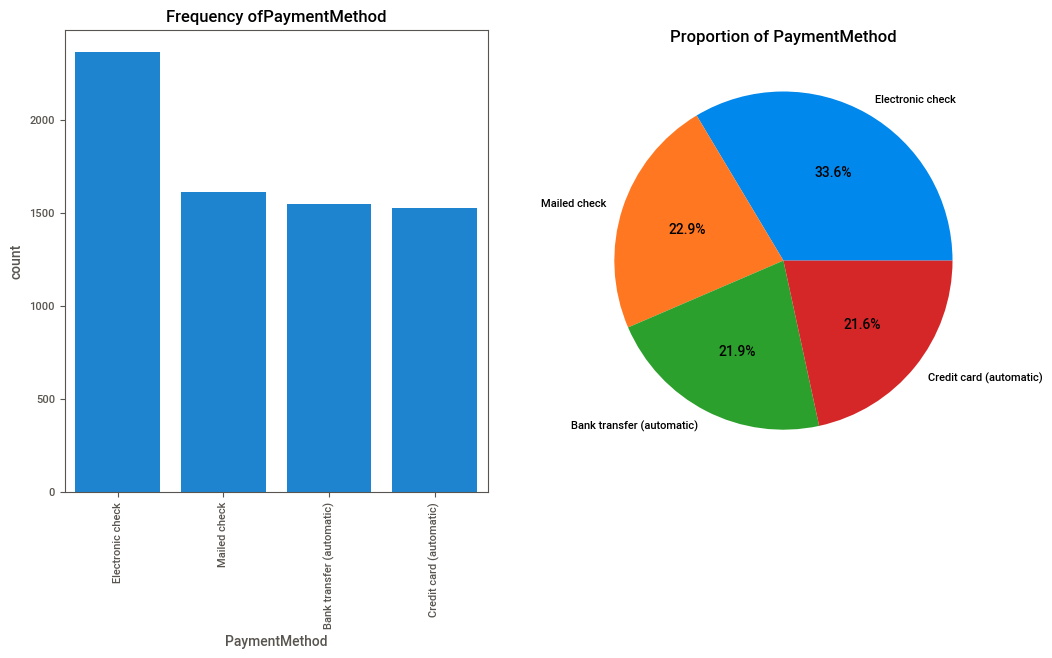

       Churn      Ratio
Churn                  
0       5174  73.463013
1       1869  26.536987
##########################################


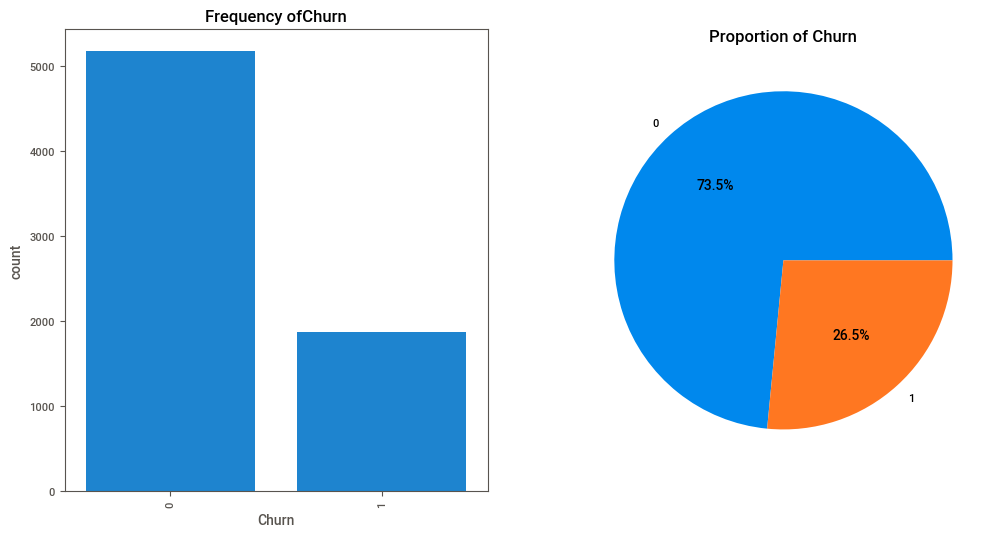

In [15]:
def cat_summary(dataframe , col_name , plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                       "Ratio": 100 * dataframe[col_name].value_counts()/len(df)}))
    print("##########################################")
    if plot:
        fig, axs = plt.subplots(1,2 , figsize=(12,6))
        sns.countplot(x=col_name, data=dataframe, ax=axs[0])
        axs[0].set_title("Frequency of" + col_name)
        axs[0].tick_params(axis='x', rotation=90)
        values= dataframe[col_name].value_counts()
        axs[1].pie(values, labels=values.index, autopct='%1.1f%%')
        axs[1].set_title("Proportion of " + col_name)
        plt.show()

for col in cat_cols:
    cat_summary(df,col, plot =True)

### Numeric Data Summary Function

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64
##########################################


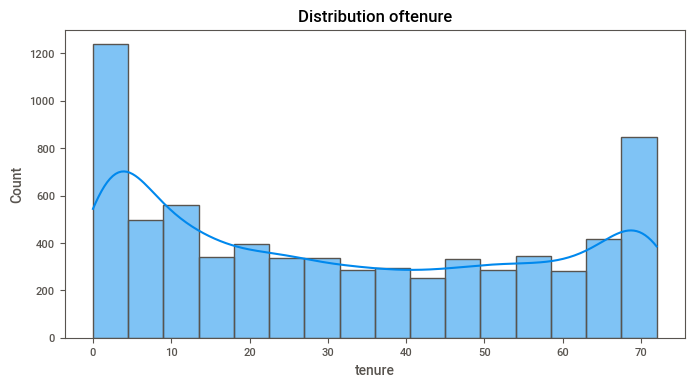

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64
##########################################


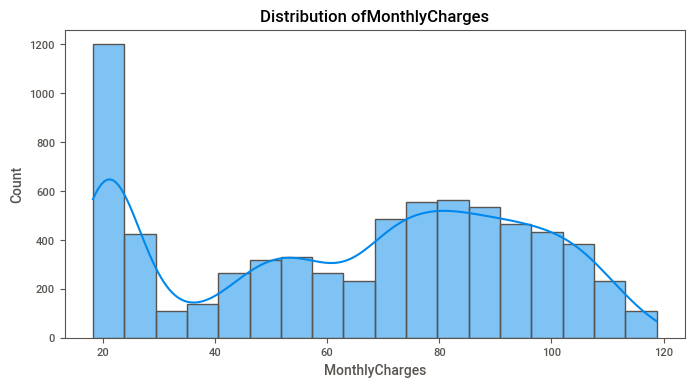

count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64
##########################################


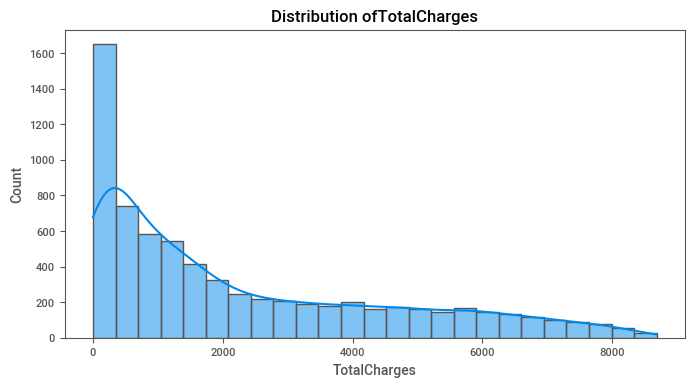

In [16]:
def num_summary(dataframe, col_name , plot=False):
    print(dataframe[col_name].describe())
    print("##########################################")
    if plot:
        plt.figure(figsize=(8,4))
        sns.histplot(dataframe[col_name], kde=True)
        plt.title("Distribution of" + col_name)
        plt.show()
    
for col in num_cols:
    num_summary(df, col, plot=True)

### Target Variable Analysis

        gender     Ratio
gender                  
Male      3555  50.47565
Female    3488  49.52435
##########################################
               SeniorCitizen      Ratio
SeniorCitizen                          
0                       5901  83.785319
1                       1142  16.214681
##########################################
         Partner     Ratio
Partner                   
No          3641  51.69672
Yes         3402  48.30328
##########################################
            Dependents      Ratio
Dependents                       
No                4933  70.041176
Yes               2110  29.958824
##########################################
              PhoneService      Ratio
PhoneService                         
Yes                   6361  90.316626
No                     682   9.683374
##########################################
               MultipleLines      Ratio
MultipleLines                          
No                      4072  57.816271
Yes      

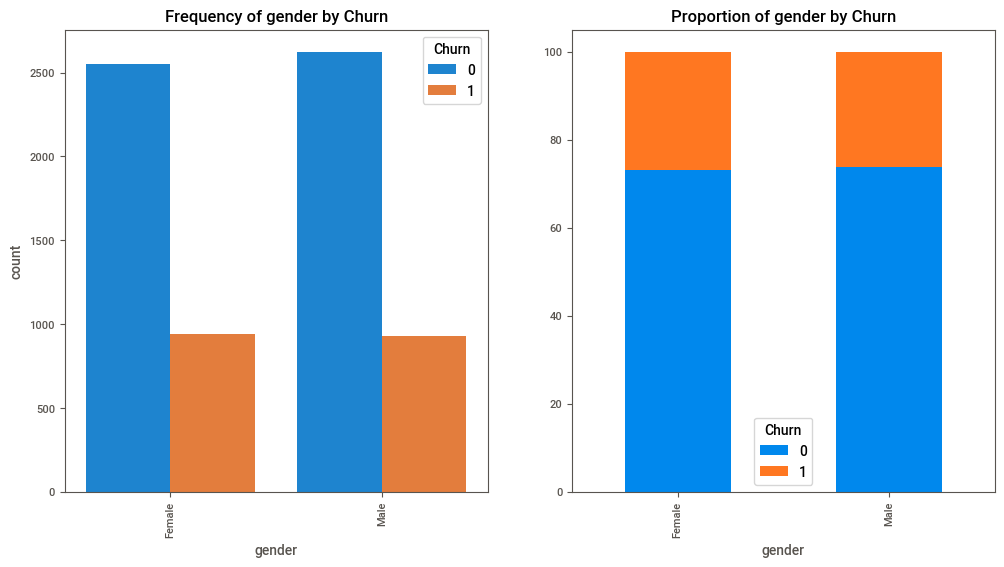

               SeniorCitizen      Ratio
SeniorCitizen                          
0                       5901  83.785319
1                       1142  16.214681
##########################################
Churn                  0          1
SeniorCitizen                      
0              76.393832  23.606168
1              58.318739  41.681261
##########################################


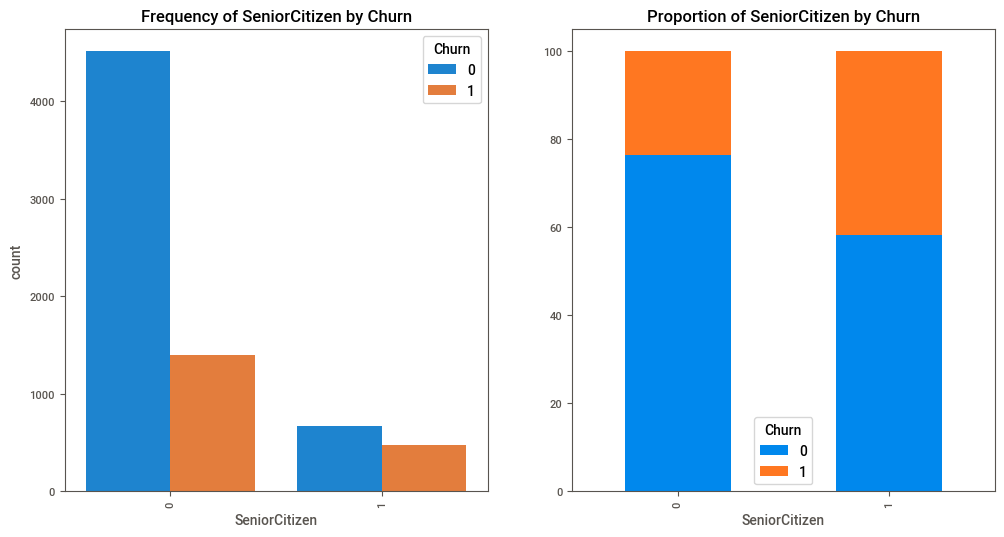

         Partner     Ratio
Partner                   
No          3641  51.69672
Yes         3402  48.30328
##########################################
Churn            0          1
Partner                      
No       67.042021  32.957979
Yes      80.335097  19.664903
##########################################


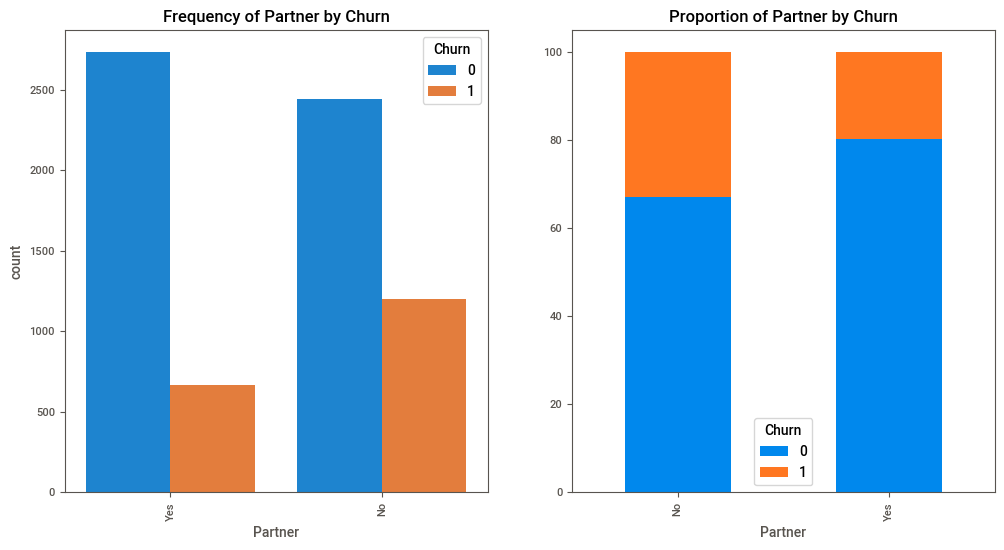

            Dependents      Ratio
Dependents                       
No                4933  70.041176
Yes               2110  29.958824
##########################################
Churn               0          1
Dependents                      
No          68.720860  31.279140
Yes         84.549763  15.450237
##########################################


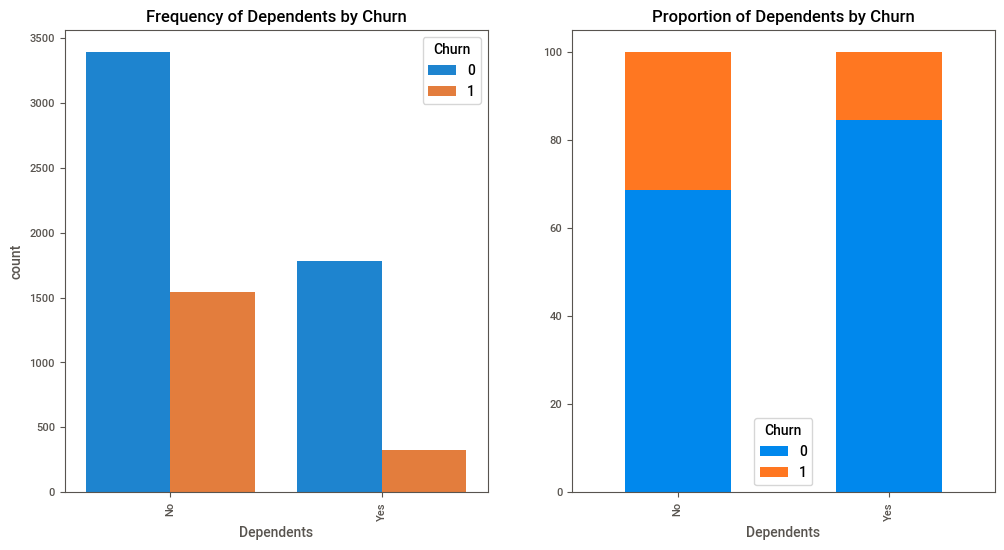

              PhoneService      Ratio
PhoneService                         
Yes                   6361  90.316626
No                     682   9.683374
##########################################
Churn                 0          1
PhoneService                      
No            75.073314  24.926686
Yes           73.290363  26.709637
##########################################


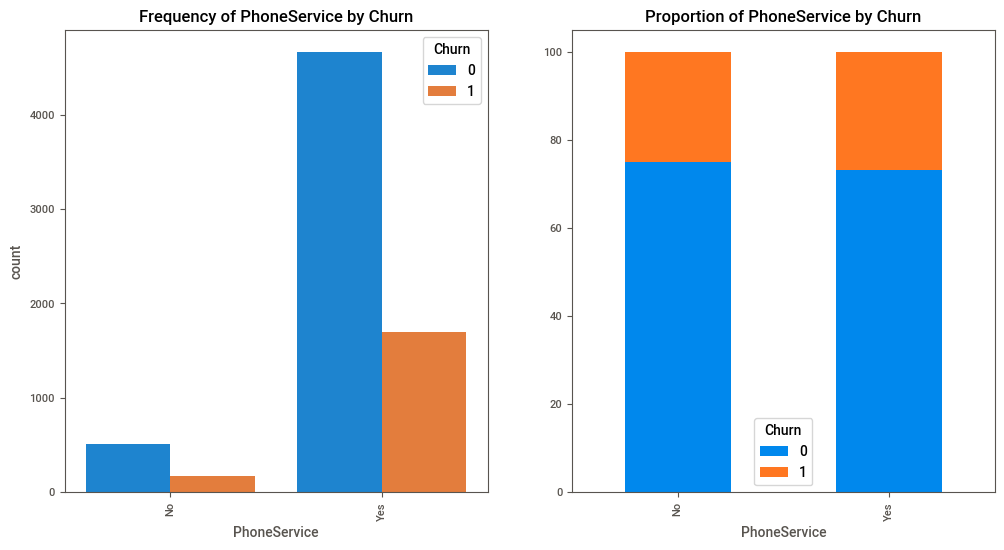

               MultipleLines      Ratio
MultipleLines                          
No                      4072  57.816271
Yes                     2971  42.183729
##########################################
Churn                  0          1
MultipleLines                      
No             74.975442  25.024558
Yes            71.390104  28.609896
##########################################


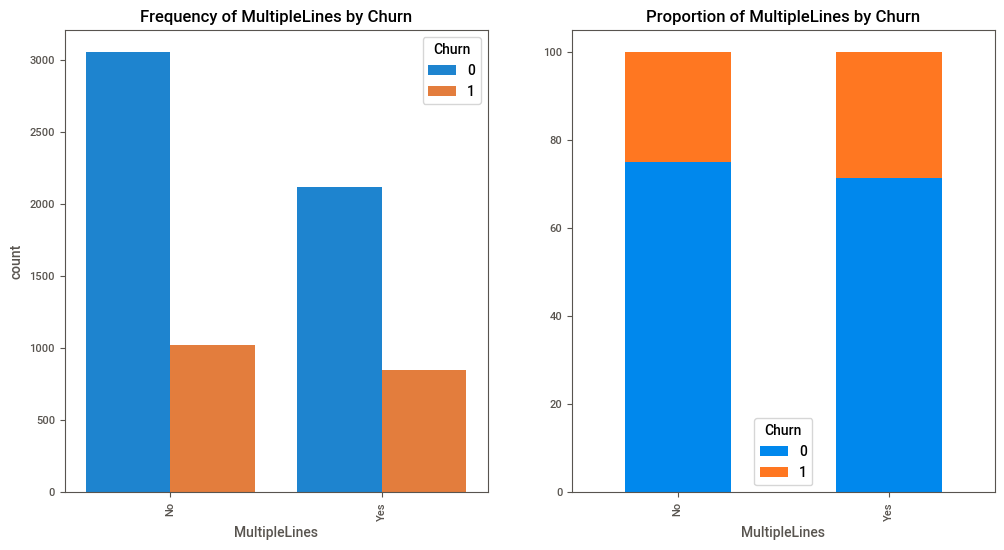

                 InternetService      Ratio
InternetService                            
Fiber optic                 3096  43.958540
DSL                         2421  34.374556
No                          1526  21.666903
##########################################
Churn                    0          1
InternetService                      
DSL              81.040892  18.959108
Fiber optic      58.107235  41.892765
No               92.595020   7.404980
##########################################


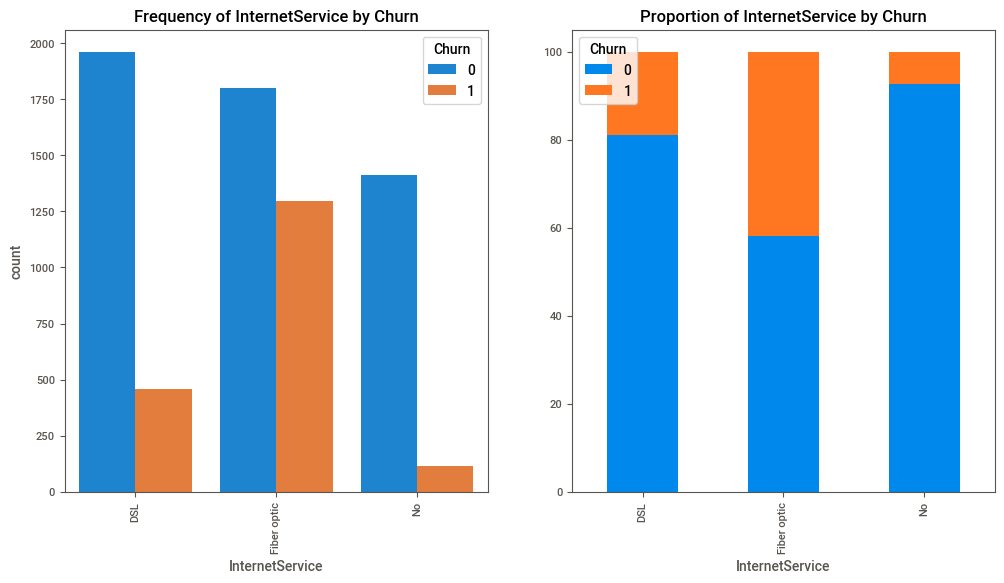

                OnlineSecurity      Ratio
OnlineSecurity                           
No                        5024  71.333239
Yes                       2019  28.666761
##########################################
Churn                   0          1
OnlineSecurity                      
No              68.670382  31.329618
Yes             85.388806  14.611194
##########################################


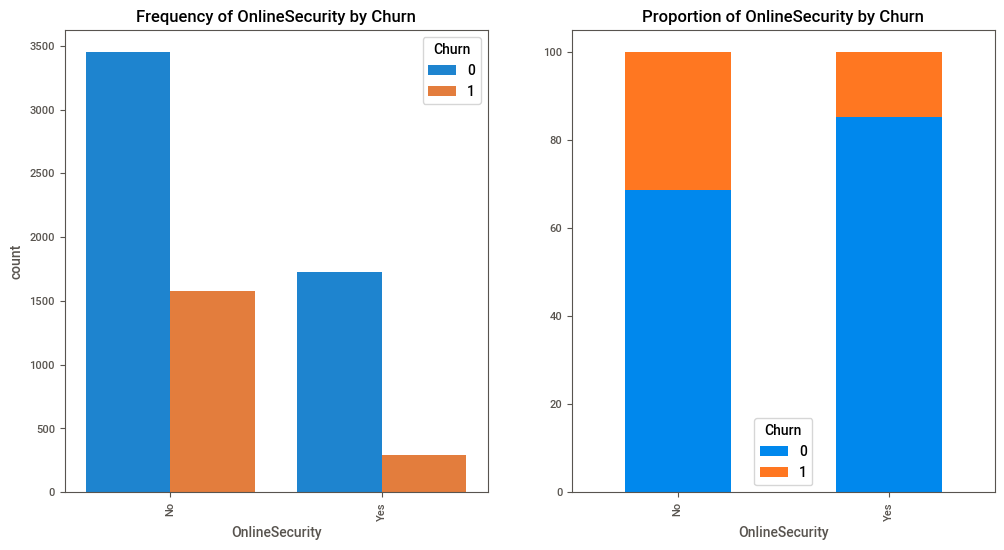

              OnlineBackup      Ratio
OnlineBackup                         
No                    4614  65.511856
Yes                   2429  34.488144
##########################################
Churn                 0          1
OnlineBackup                      
No            70.827915  29.172085
Yes           78.468506  21.531494
##########################################


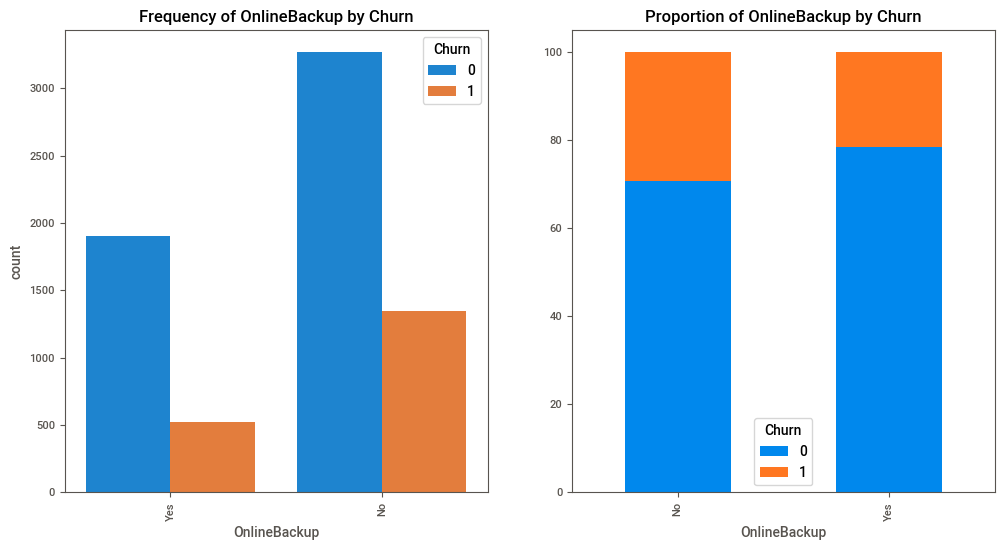

                  DeviceProtection      Ratio
DeviceProtection                             
No                            4621  65.611245
Yes                           2422  34.388755
##########################################
Churn                     0          1
DeviceProtection                      
No                71.348193  28.651807
Yes               77.497936  22.502064
##########################################


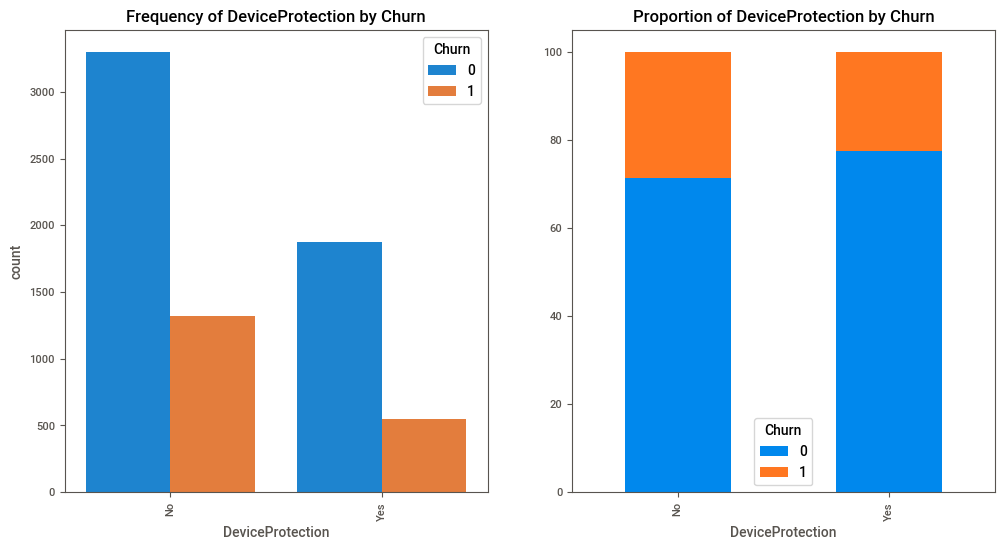

             TechSupport      Ratio
TechSupport                        
No                  4999  70.978276
Yes                 2044  29.021724
##########################################
Churn                0          1
TechSupport                      
No           68.813763  31.186237
Yes          84.833659  15.166341
##########################################


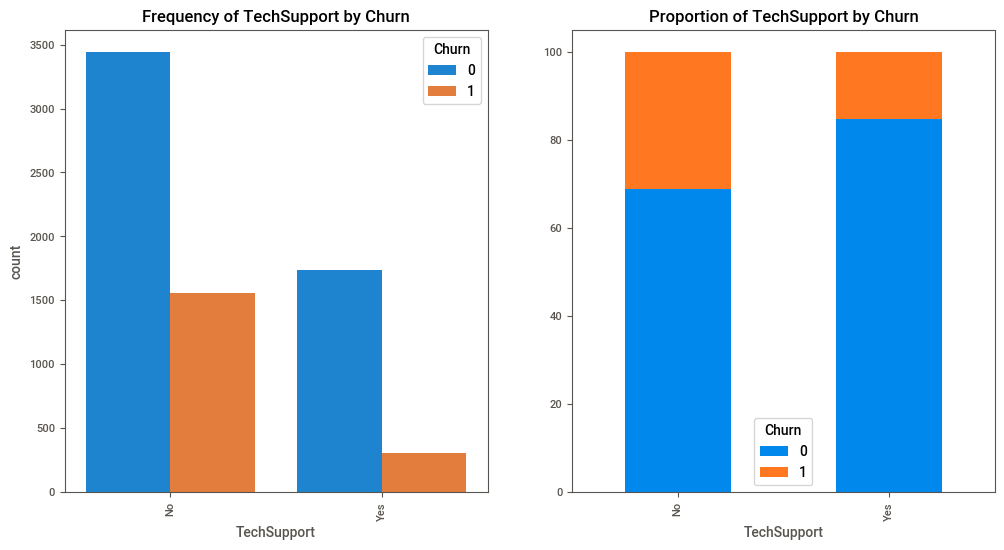

             StreamingTV      Ratio
StreamingTV                        
No                  4336  61.564674
Yes                 2707  38.435326
##########################################
Churn                0          1
StreamingTV                      
No           75.668819  24.331181
Yes          69.929812  30.070188
##########################################


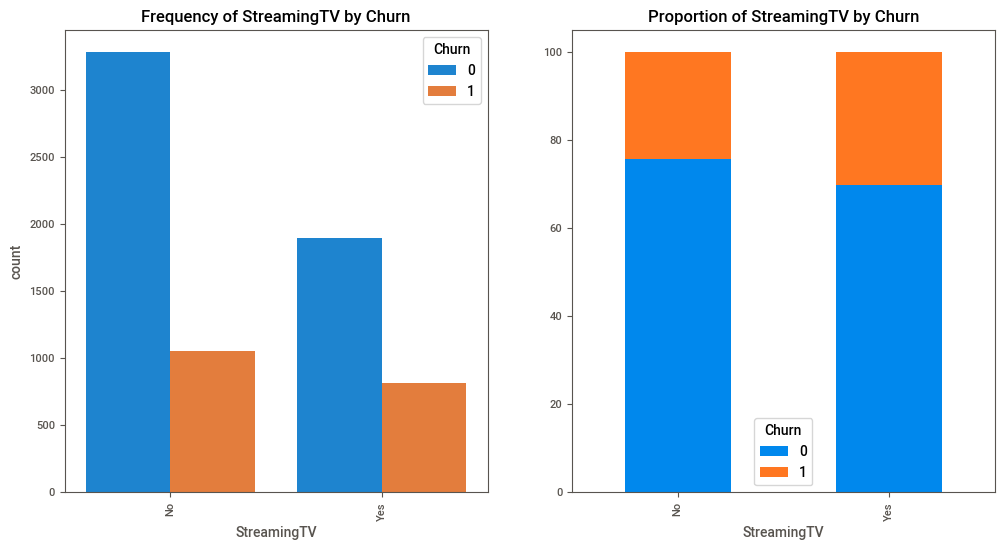

                 StreamingMovies      Ratio
StreamingMovies                            
No                          4311  61.209712
Yes                         2732  38.790288
##########################################
Churn                    0          1
StreamingMovies                      
No               75.620506  24.379494
Yes              70.058565  29.941435
##########################################


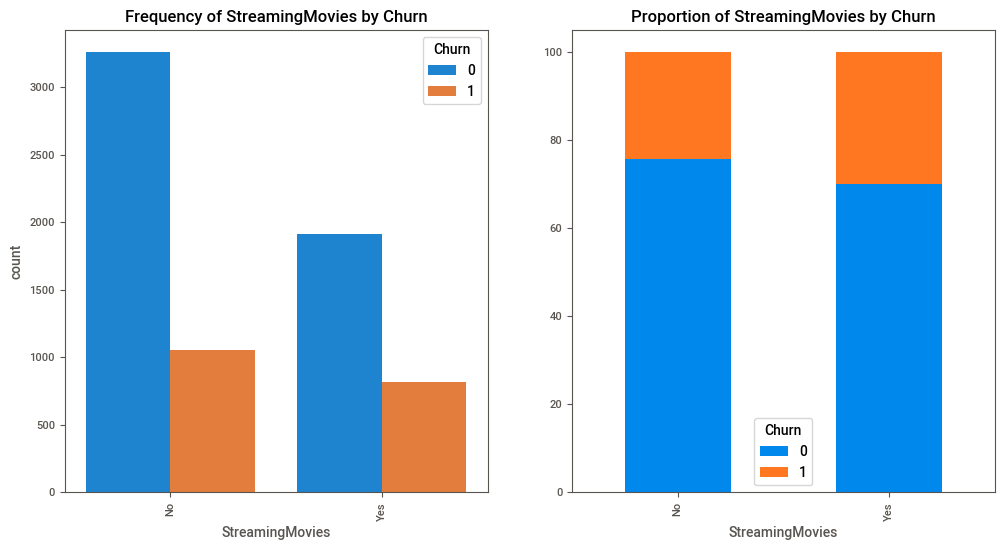

                Contract      Ratio
Contract                           
Month-to-month      3875  55.019168
Two year            1695  24.066449
One year            1473  20.914383
##########################################
Churn                   0          1
Contract                            
Month-to-month  57.290323  42.709677
One year        88.730482  11.269518
Two year        97.168142   2.831858
##########################################


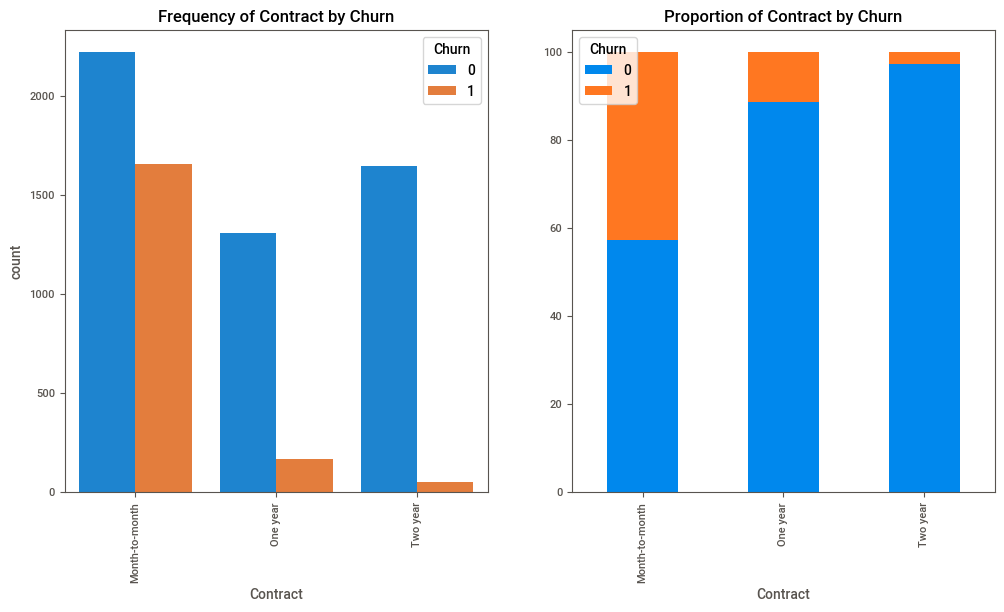

                  PaperlessBilling      Ratio
PaperlessBilling                             
Yes                           4171  59.221922
No                            2872  40.778078
##########################################
Churn                     0          1
PaperlessBilling                      
No                83.669916  16.330084
Yes               66.434908  33.565092
##########################################


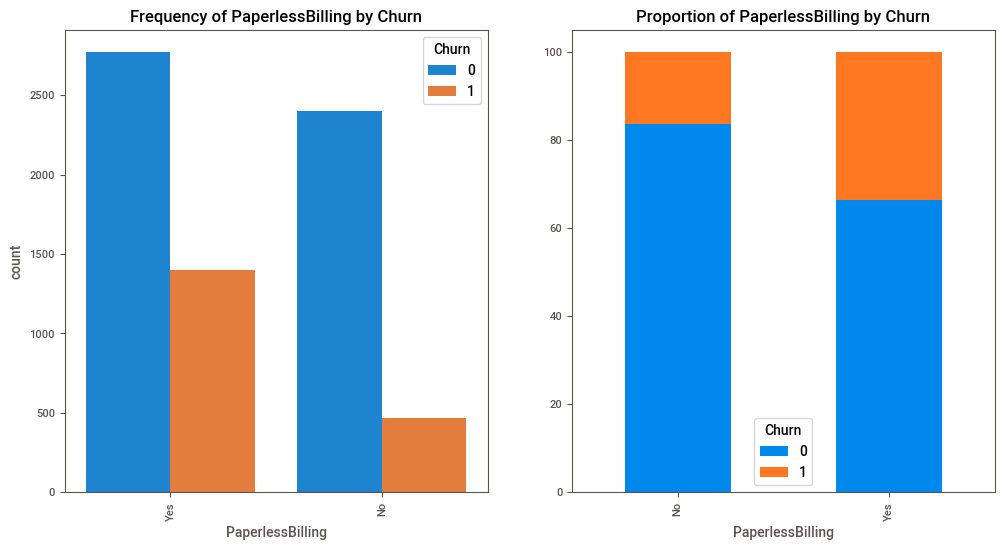

                           PaymentMethod      Ratio
PaymentMethod                                      
Electronic check                    2365  33.579441
Mailed check                        1612  22.887974
Bank transfer (automatic)           1544  21.922476
Credit card (automatic)             1522  21.610109
##########################################
Churn                              0          1
PaymentMethod                                  
Bank transfer (automatic)  83.290155  16.709845
Credit card (automatic)    84.756899  15.243101
Electronic check           54.714588  45.285412
Mailed check               80.893300  19.106700
##########################################


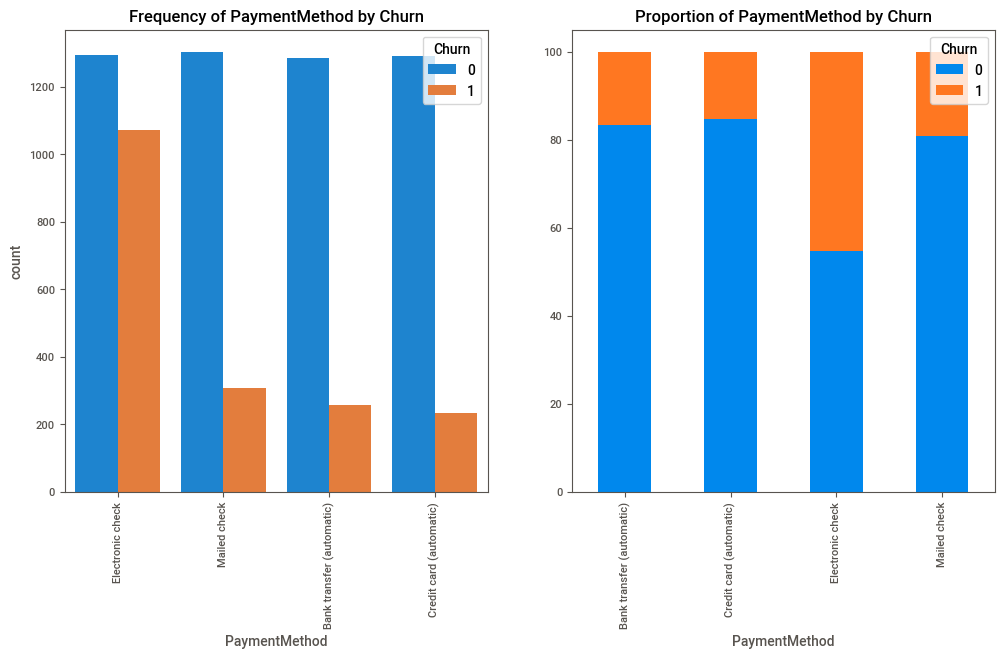

       Churn      Ratio
Churn                  
0       5174  73.463013
1       1869  26.536987
##########################################
Churn      0      1
Churn              
0      100.0    0.0
1        0.0  100.0
##########################################


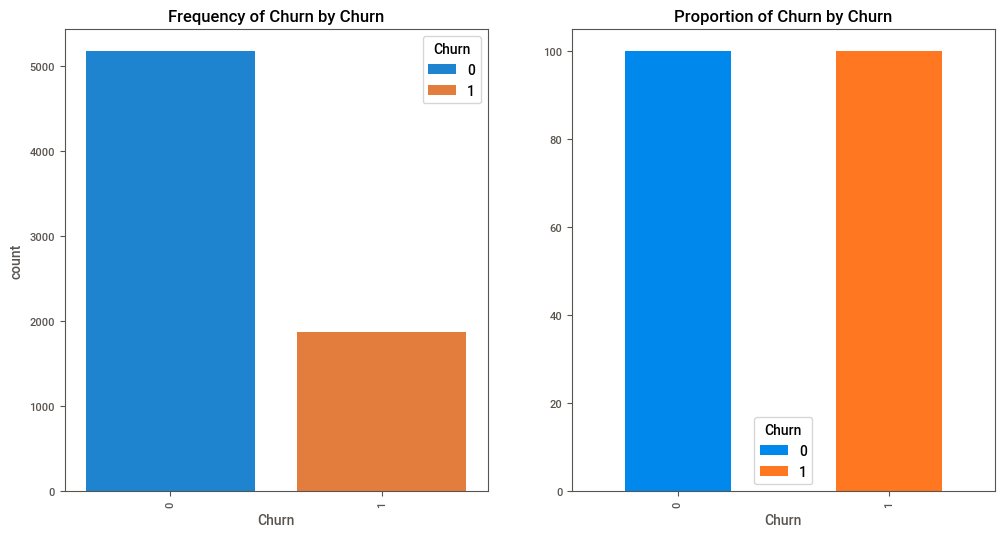

          tenure  MonthlyCharges  TotalCharges
Churn                                         
0      37.569965       61.265124   2549.911442
1      17.979133       74.441332   1531.796094


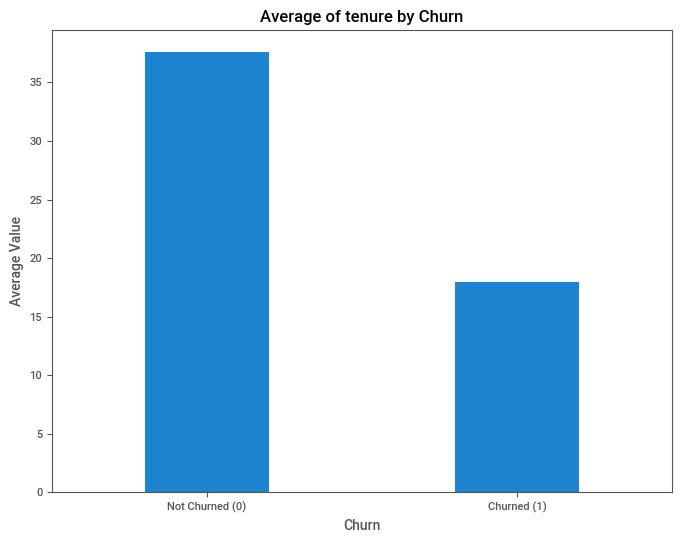

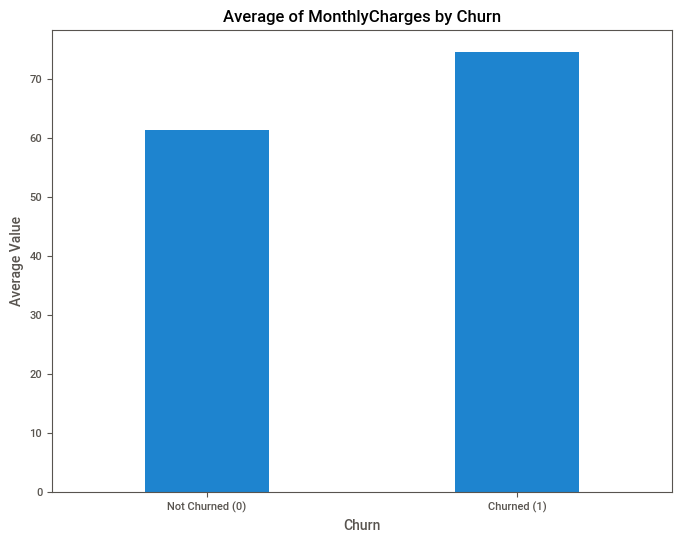

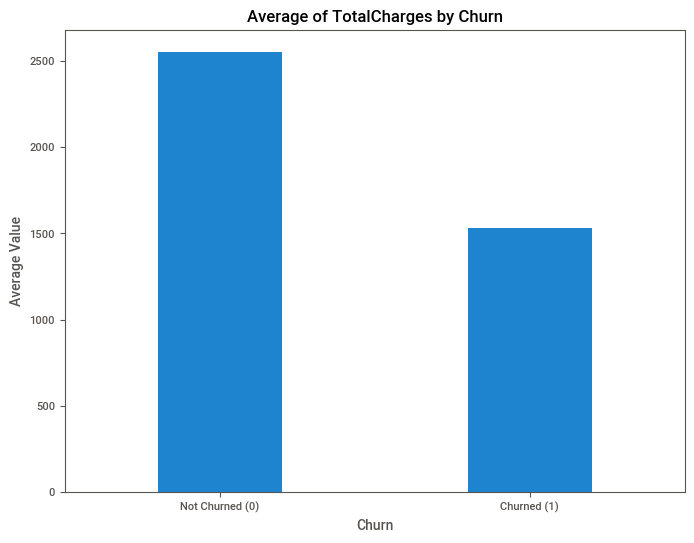

In [17]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                       "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        sns.countplot(x=col_name, data=dataframe, ax=axs[0])
        axs[0].set_title("Frequency of " + col_name)
        axs[0].tick_params(axis='x', rotation=90)
        values = dataframe[col_name].value_counts()
        axs[1].pie(values, labels=values.index, autopct='%1.1f%%')
        axs[1].set_title("Proportion of " + col_name)
        plt.show()

for col in cat_cols:
    cat_summary(df, col, plot=False)
    
def cat_summary_with_target(dataframe, col_name, target, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                       "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    cross_tab = pd.crosstab(dataframe[col_name], dataframe[target], normalize='index') * 100
    print(cross_tab)
    print("##########################################")
    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        sns.countplot(x=col_name, hue=target, data=dataframe, ax=axs[0])
        axs[0].set_title(f'Frequency of {col_name} by {target}')
        axs[0].tick_params(axis='x', rotation=90)
        cross_tab.plot(kind='bar', stacked=True, ax=axs[1])
        axs[1].set_title(f'Proportion of {col_name} by {target}')
        axs[1].legend(title=target)
        plt.show()

for col in cat_cols:
    cat_summary_with_target(df, col, 'Churn', plot=True)

grouped = df.groupby('Churn')[num_cols].mean()
print(grouped)

for col in num_cols:
    plt.figure(figsize=(8, 6))
    sns.barplot(x=grouped.index, y=grouped[col],width=0.4)
    plt.title(f'Average of {col} by Churn')
    plt.ylabel('Average Value')
    plt.xlabel('Churn')
    plt.xticks(ticks=[0, 1], labels=['Not Churned (0)', 'Churned (1)'])
    plt.show()

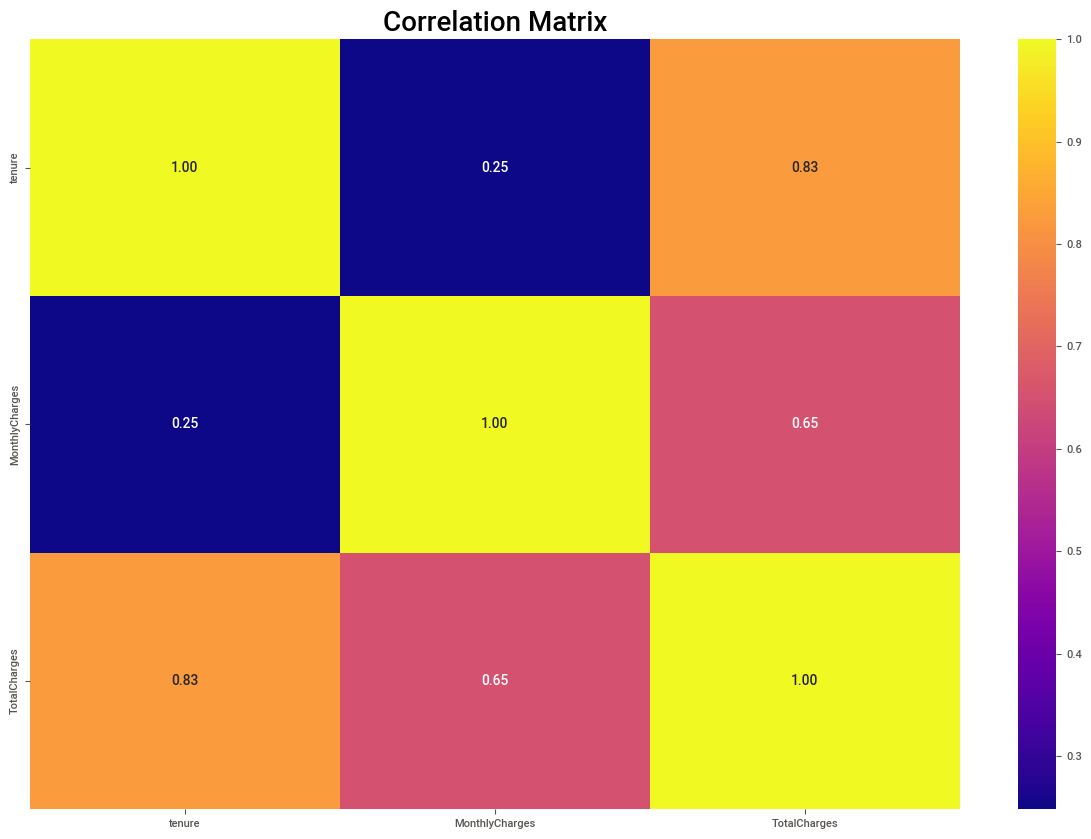

In [18]:
# Correlation Analysis
df[num_cols].corr()
f,ax = plt.subplots(figsize=[15,10])
sns.heatmap(df[num_cols].corr(), annot = True, fmt=".2f" ,ax=ax , cmap="plasma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [19]:
# Outlier Analysis
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quantile1 = dataframe[col_name].quantile(q1)
    quantile3 = dataframe[col_name].quantile(q3)
    IQR = quantile3 - quantile1
    low_limit = quantile1 - 1.5 * IQR
    up_limit = quantile3 + 1.5 * IQR
    return low_limit, up_limit



def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name]>up_limit) | (dataframe[col_name]<low_limit) ].any(axis=None):
        return True
    else:
        return False
    
for col in num_cols:
    print(col, outlier_thresholds(df, col))
for col in num_cols:
    print(col, check_outlier(df, col))
print(df[["tenure","MonthlyCharges","TotalCharges"]].describe().T)

tenure (-105.5, 178.5)
MonthlyCharges (-111.975, 239.025)
TotalCharges (-10260.037499999997, 17229.662499999995)
tenure False
MonthlyCharges False
TotalCharges False
                 count         mean          std    min     25%      50%  \
tenure          7043.0    32.371149    24.559481   0.00    9.00    29.00   
MonthlyCharges  7043.0    64.761692    30.090047  18.25   35.50    70.35   
TotalCharges    7043.0  2279.734304  2266.794470   0.00  398.55  1394.55   

                    75%      max  
tenure            55.00    72.00  
MonthlyCharges    89.85   118.75  
TotalCharges    3786.60  8684.80  


In [20]:
# Missing Values Analysis
def missing_values_table(dataframe, na_name=True):
    na_columns = [col for col in dataframe if dataframe[col].isnull().sum()>0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=["n_miss", "ratio"])
    print(missing_df)
    if na_name:
        return na_columns
missing_columns = missing_values_table(df)
print("Columns with missing values:", missing_columns)

missing_values_table(df, True)
na_cols = missing_values_table(df, True)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []
Columns with missing values: []
Empty DataFrame
Columns: [n_miss, ratio]
Index: []
Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [16]:
# Feature Engineering
# TotalCharges sütununu sayısal tipe dönüştürme
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# TotalChargesPerMonth değişkeninin oluşturulması
df['TotalChargesPerMonth'] = df['TotalCharges'] / df['tenure'].replace(0, np.nan)
df['TotalChargesPerMonth'].fillna(0, inplace=True)

# Tenure değişkenini gruplama
bins = [0, 12, 24, 36, 48, 60, np.inf]
labels = ['0-12 months', '13-24 months', '25-36 months', '37-48 months', '49-60 months', '60+ months']
df['TenureGroup'] = pd.cut(df['tenure'], bins=bins, labels=labels, right=False)

# Alınan hizmetlerin sayısını hesaplama
service_columns = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                   'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df['NumberOfServicesUsed'] = df[service_columns].apply(lambda x: sum(x == 'Yes'), axis=1)

# MonthlyChargesPerService değişkeninin oluşturulması
df['MonthlyChargesPerService'] = df['MonthlyCharges'] / df['NumberOfServicesUsed'].replace(0, np.nan)
df['MonthlyChargesPerService'].fillna(0, inplace=True)

# SeniorCitizenBinary değişkeninin oluşturulması
df['SeniorCitizenBinary'] = df['SeniorCitizen'].apply(lambda x: 'Yes' if x == 1 else 'No')

# ContractType değişkeninin oluşturulması
df['ContractType'] = df['Contract'].apply(lambda x: 'Monthly' if x == 'Month-to-month' else 'Long-term')

# StreamingServicesUsed değişkeninin oluşturulması
df['StreamingServicesUsed'] = df[['StreamingTV', 'StreamingMovies']].apply(lambda x: 'Yes' if 'Yes' in x.values else 'No', axis=1)

# Yeni değişkenlerin özetini görüntüleme
df[['TotalChargesPerMonth', 'TenureGroup', 'NumberOfServicesUsed', 'MonthlyChargesPerService', 'SeniorCitizenBinary', 'ContractType', 'StreamingServicesUsed']].head()

C:\Users\frany\AppData\Local\Temp\ipykernel_25848\2712907374.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalChargesPerMonth'].fillna(0, inplace=True)


   TotalChargesPerMonth   TenureGroup  NumberOfServicesUsed  \
0             29.850000   0-12 months                     1   
1             55.573529  25-36 months                     3   
2             54.075000   0-12 months                     3   
3             40.905556  37-48 months                     3   
4             75.825000   0-12 months                     1   

   MonthlyChargesPerService SeniorCitizenBinary ContractType  \
0                 29.850000                  No      Monthly   
1                 18.983333                  No    Long-term   
2                 17.950000                  No      Monthly   
3                 14.100000                  No    Long-term   
4                 70.700000                  No      Monthly   

  StreamingServicesUsed  
0                    No  
1                    No  
2                    No  
3                    No  
4                    No  


C:\Users\frany\AppData\Local\Temp\ipykernel_25848\2712907374.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['MonthlyChargesPerService'].fillna(0, inplace=True)


## CATBOOST 

In [33]:
# Identify categorical columns
categorical_columns = df_.select_dtypes(include=['object']).columns.tolist()
# df[categorical_columns] = df[categorical_columns].astype('category')

# Initialize and fit CatBoostClassifier
cat_model = CatBoostClassifier(verbose=False, random_state=0, scale_pos_weight=3)
cat_model.fit(X_train, y_train, cat_features=categorical_columns, eval_set=(X_test, y_test))

# Predict on test set
y_pred = cat_model.predict(X_test)

# Calculate evaluation metrics
## Metrics
accuracy, recall, roc_auc, precision = [round(metric(y_test, y_pred), 4) for metric in [accuracy_score, recall_score, roc_auc_score, precision_score]]
# Calcular F1-score
f1 = f1_score(y_test, y_pred)

# Create a DataFrame to store results
model_names = ['CatBoost_Model']
result = pd.DataFrame({'Accuracy': accuracy, 'Recall': recall, 'Roc_Auc': roc_auc,
                       'Precision': precision, 'f1_score':f1}, index=model_names)

# Print results
print(result)

# Save the model in the 'model' directory, with 
# !mkdir model
os.chdir('../src/')
model_dir = "model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_path = os.path.join(model_dir, "catboost_model.cbm")
cat_model.save_model(model_path)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
print(conf_matrix)


                Accuracy  Recall  Roc_Auc  Precision  f1_score
CatBoost_Model    0.7764  0.8262   0.7923     0.5528  0.662379
Matriz de confusión:
[[785 250]
 [ 65 309]]


In [34]:
X_train.head(4)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
3174,6968-MHOMU,Male,0,Yes,No,58,No,No,DSL,No,No,No,No,Yes,Yes,One year,Yes,Credit card (automatic),45.00,2689.35
3896,8590-OHDIW,Female,0,Yes,Yes,38,Yes,No,No,No,No,No,No,No,No,One year,No,Mailed check,20.30,749.35
1445,3211-AAPKX,Male,0,No,No,20,Yes,Yes,Fiber optic,No,No,No,Yes,Yes,Yes,Month-to-month,Yes,Mailed check,98.55,2031.95
5670,7812-FZHPE,Female,0,Yes,Yes,17,Yes,Yes,No,No,No,No,No,No,No,Month-to-month,No,Mailed check,24.10,409.90


In [35]:
y_test.value_counts()

Churn
0    1035
1     374
Name: count, dtype: int64

## Load model

In [36]:
# Convertir el DataFrame de pandas a una tabla de PyArrow
table = pa.Table.from_pandas(df)

# Escribir la tabla en un archivo Parquet
pq.write_table(table, '../data/process/churn_data_regulated.parquet')

In [37]:
# Path of the trained model and data
MODEL_PATH = "../src/model/catboost_model.cbm" 
DATA_PATH = "../data/process/churn_data_regulated.parquet"

In [38]:
st.set_page_config(page_title="Churn Project")

2024-10-06 21:26:26.407 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [39]:
# @title Functions

# @markdown
@st.cache_resource
def load_data():
    data = pd.read_parquet(DATA_PATH)
    return data

def load_x_y(file_path):
    data = joblib.load(file_path)
    data.reset_index(drop=True, inplace=True)
    return data

def load_model():
    model = CatBoostClassifier()
    model.load_model(MODEL_PATH)
    return model

def calculate_shap(model, X_train, X_test):
    # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values_cat_train = explainer.shap_values(X_train)
    shap_values_cat_test = explainer.shap_values(X_test)
    return explainer, shap_values_cat_train, shap_values_cat_test

def plot_shap_values(model, explainer, shap_values_cat_train, shap_values_cat_test, customer_id, X_test, X_train):
    # Visualize SHAP values for a specific customer
    customer_index = X_test[X_test['customerID'] == customer_id].index[0]
    fig, ax_2 = plt.subplots(figsize=(6,6), dpi=200)
    shap.decision_plot(explainer.expected_value, shap_values_cat_test[customer_index], X_test[X_test['customerID'] == customer_id], link="logit")
    st.pyplot(fig)
    plt.close()

def display_shap_summary(shap_values_cat_train, X_train):
    # Create the plot summarizing the SHAP values
    shap.summary_plot(shap_values_cat_train, X_train, plot_type="bar", plot_size=(12,12))
    summary_fig, _ = plt.gcf(), plt.gca()
    st.pyplot(summary_fig)
    plt.close()

def display_shap_waterfall_plot(explainer, expected_value, shap_values, feature_names, max_display=20):
    # Create SHAP waterfall drawing
    fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
    shap.plots._waterfall.waterfall_legacy(expected_value, shap_values, feature_names=feature_names, max_display=max_display, show=False)
    st.pyplot(fig)
    plt.close()

def summary(model, data, X_train, X_test):
    # Calculate SHAP values
    explainer, shap_values_cat_train, shap_values_cat_test = calculate_shap(model, X_train, X_test)

    # Summarize and visualize SHAP values
    display_shap_summary(shap_values_cat_train, X_train)

def plot_shap(model, data, customer_id, X_train, X_test):
    # Calculate SHAP values
    explainer, shap_values_cat_train, shap_values_cat_test = calculate_shap(model, X_train, X_test)
    
    # Visualize SHAP values
    plot_shap_values(model, explainer, shap_values_cat_train, shap_values_cat_test, customer_id, X_test, X_train)

    # Waterfall
    customer_index = X_test[X_test['customerID'] == customer_id].index[0]
    display_shap_waterfall_plot(explainer, explainer.expected_value, shap_values_cat_test[customer_index], feature_names=X_test.columns, max_display=20)


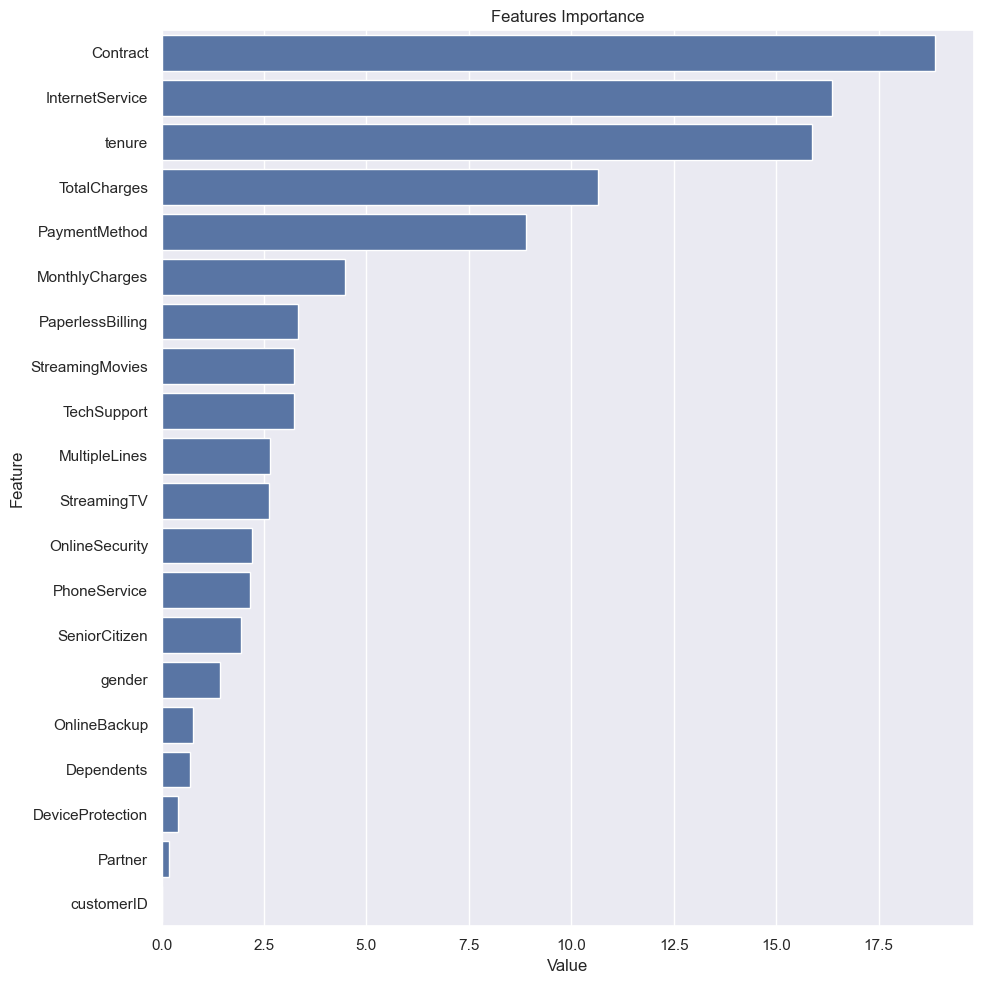

<Figure size 640x480 with 0 Axes>

In [40]:
# Feature Importance
def plot_importance(model, features, save=False):
    feature_importances = model.get_feature_importance()
    feature_imp = pd.DataFrame({"Value": feature_importances, "Feature": features.columns})
    plt.figure(figsize=(10, 10))
    sns.set_theme(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title("Features Importance")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("../data/process/importances.png")
model = load_model()
plot_importance(model, X_train, True)

In [41]:
st.title("Telco Customer Churn Project")

2024-10-06 21:26:30.097 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-06 21:26:30.848 
  command:

    streamlit run d:\Programs\Anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2024-10-06 21:26:30.874 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

2024-10-06 21:26:32.575 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-06 21:26:32.576 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-06 21:26:32.577 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-06 21:26:33.120 Thread 'Thread-29': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-06 21:26:33.133 Thread 'Thread-29': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-06 21:26:33.696 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-06 21:26:33.697 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-06 21:26:33.839 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare 

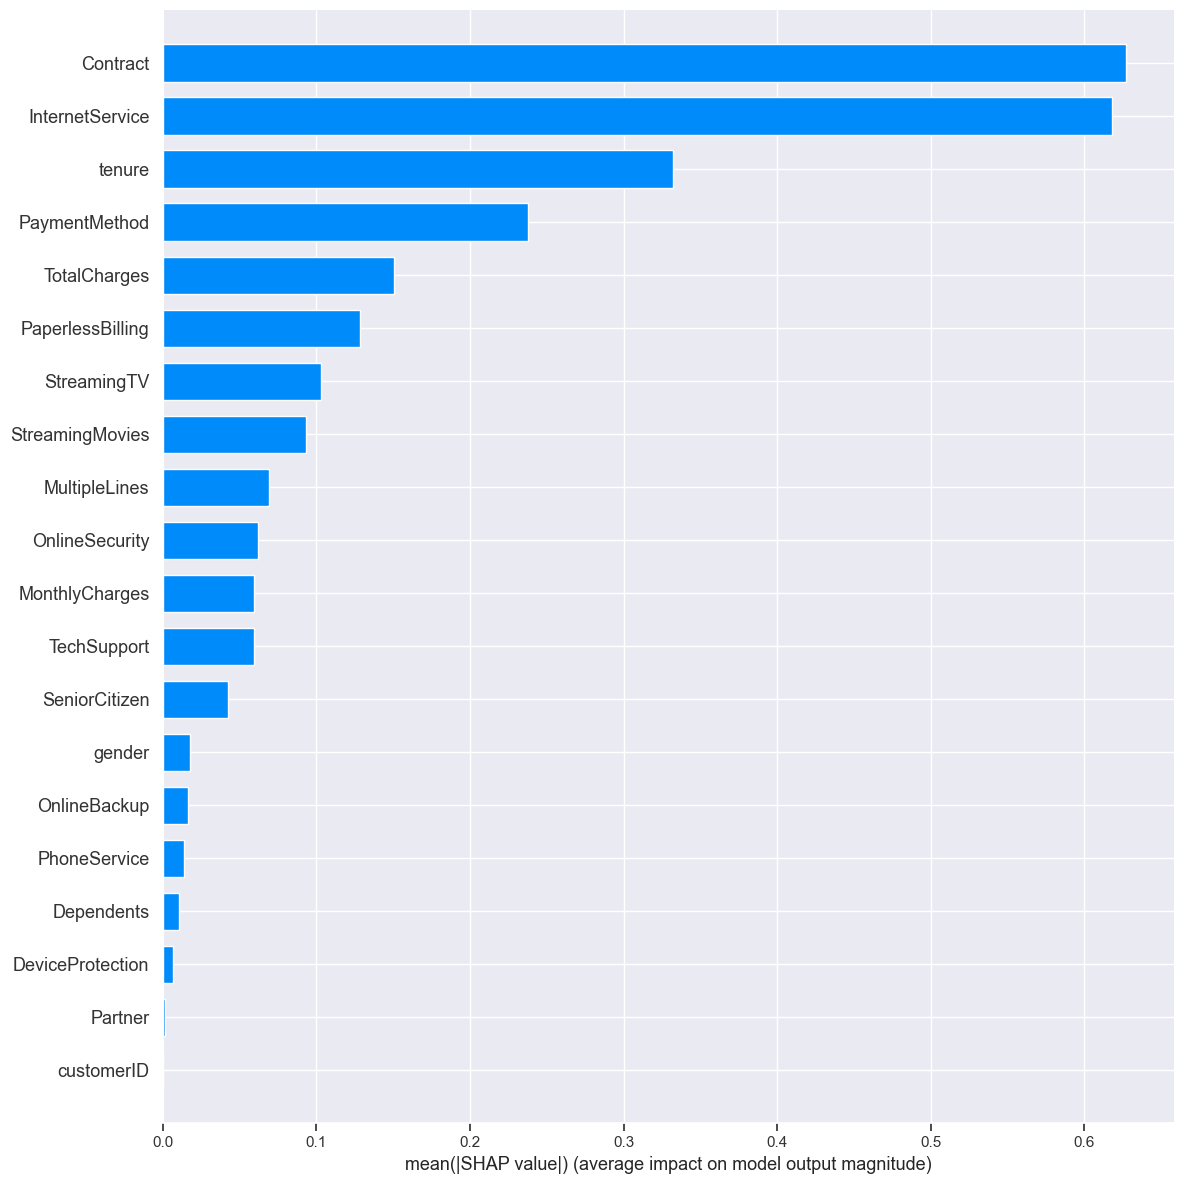

2024-10-06 21:26:35.273 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-06 21:26:35.443 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-06 21:26:35.444 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [42]:
# @title Project in streamlit-app.py
def main():
    model = load_model()
    data = load_data()
    
    X_train = load_x_y("../data/process/X_train.pkl")
    X_test = load_x_y("../data/process/X_test.pkl")
    y_train = load_x_y("../data/process/y_train.pkl")
    y_test = load_x_y("../data/process/y_test.pkl")

    max_tenure = data['tenure'].max()
    max_monthly_charges = data['MonthlyCharges'].max()
    max_total_charges = data['TotalCharges'].max()

    # Radio buttons for options
    election = st.radio("Make Your Choice:", ("Feature Importance", "User-based SHAP", "Calculate the probability of CHURN"))
    available_customer_ids = X_test['customerID'].tolist()
    
    # If User-based SHAP option is selected
    if election == "User-based SHAP":
        # Customer ID text input
        customer_id = st.selectbox("Choose the Customer", available_customer_ids)
        customer_index = X_test[X_test['customerID'] == customer_id].index[0]
        st.write(f'Customer {customer_id}: Actual value for the Customer Churn : {y_test.iloc[customer_index]}')
        y_pred = model.predict(X_test)
        st.write(f"Customer {customer_id}: CatBoost Model's prediction for the Customer Churn : {y_pred[customer_index]}")
        plot_shap(model, data, customer_id, X_train=X_train, X_test=X_test)
    
    # If Feature Importance is selected
    elif election == "Feature Importance":
        summary(model, data, X_train=X_train, X_test=X_test)

    # If Calculate CHURN Probability option is selected
    elif election == "Calculate the probability of CHURN":
        # Retrieving data from the user
        customerID = "6464-UIAEA"
        gender = st.selectbox("Gender:", ("Female", "Male"))
        senior_citizen = st.number_input("SeniorCitizen (0: No, 1: Yes)", min_value=0, max_value=1, step=1)
        partner = st.selectbox("Partner:", ("No", "Yes"))
        dependents = st.selectbox("Dependents:", ("No", "Yes"))
        tenure = st.number_input("Tenure:", min_value=0, max_value=max_tenure, step=1)
        phone_service = st.selectbox("PhoneService:", ("No", "Yes"))
        multiple_lines = st.selectbox("MultipleLines:", ("No", "Yes"))
        internet_service = st.selectbox("InternetService:", ("No", "DSL", "Fiber optic"))
        online_security = st.selectbox("OnlineSecurity:", ("No", "Yes"))
        online_backup = st.selectbox("OnlineBackup:", ("No", "Yes"))
        device_protection = st.selectbox("DeviceProtection:", ("No", "Yes"))
        tech_support = st.selectbox("TechSupport:", ("No", "Yes"))
        streaming_tv = st.selectbox("StreamingTV:", ("No", "Yes"))
        streaming_movies = st.selectbox("StreamingMovies:", ("No", "Yes"))
        contract = st.selectbox("Contract:", ("Month-to-month", "One year", "Two year"))
        paperless_billing = st.selectbox("PaperlessBilling", ("No", "Yes"))
        payment_method = st.selectbox("PaymentMethod:", ("Electronic check", "Mailed check", "Bank transfer (automatic)", "Credit card (automatic)"))
        monthly_charges = st.number_input("Monthly Charges", min_value=0.0, max_value=max_monthly_charges, step=0.01)
        total_charges = st.number_input("Total Charges", min_value=0.0, max_value=max_total_charges, step=0.01)
        
        # Confirmation button
        confirmation_button = st.button("Confirm")

        # When the confirmation button is clicked
        if confirmation_button:
            # Convert user-entered data into a data frame
            new_customer_data = pd.DataFrame({
                "customerID": [customerID],
                "gender": [gender],
                "SeniorCitizen": [senior_citizen],
                "Partner": [partner],
                "Dependents": [dependents],
                "tenure": [tenure],
                "PhoneService": [phone_service],
                "MultipleLines": [multiple_lines],
                "InternetService": [internet_service],
                "OnlineSecurity": [online_security],
                "OnlineBackup": [online_backup],
                "DeviceProtection": [device_protection],
                "TechSupport": [tech_support],
                "StreamingTV": [streaming_tv],
                "StreamingMovies": [streaming_movies],
                "Contract": [contract],
                "PaperlessBilling": [paperless_billing],
                "PaymentMethod": [payment_method],
                "MonthlyCharges": [monthly_charges],
                "TotalCharges": [total_charges]
            })

            # Predict churn probability using the model
            churn_probability = model.predict_proba(new_customer_data)[:, 1]

            # Format churn probability
            formatted_churn_probability = "{:.2%}".format(churn_probability.item())

            big_text = f"<h1>Churn Probability: {formatted_churn_probability}</h1>"
            st.markdown(big_text, unsafe_allow_html=True)
            st.write(new_customer_data.to_dict())

if __name__ == "__main__":
    main()

In [1]:
# !python -m pip freeze > requirements.txt

### On forecasting churn

The longer you track churn, the more patterns you see. What you will certainly see, is that certain conditions make customers more likely to churn. And that’s exactly when you can intervene with an irresistible offer.

Additionally, forecasting churn will help you plan ahead. Unless you know how much you’ll be making in the next couple of months with a decent degree of certainty, there’s no use planning.

The most common technique for churn forecasting is survival analysis. Survival analysis is a statistical technique that estimates the probability of customers churning over a certain period.



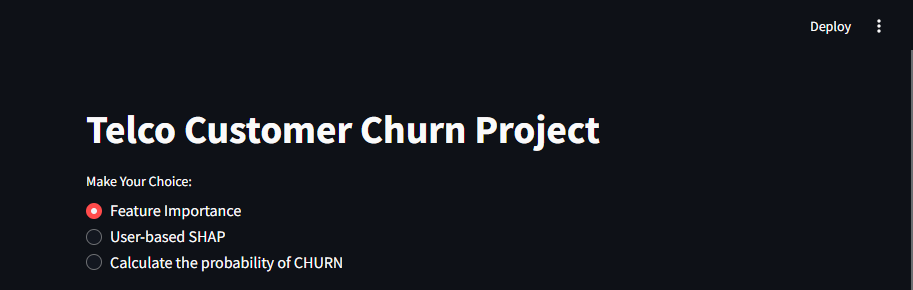

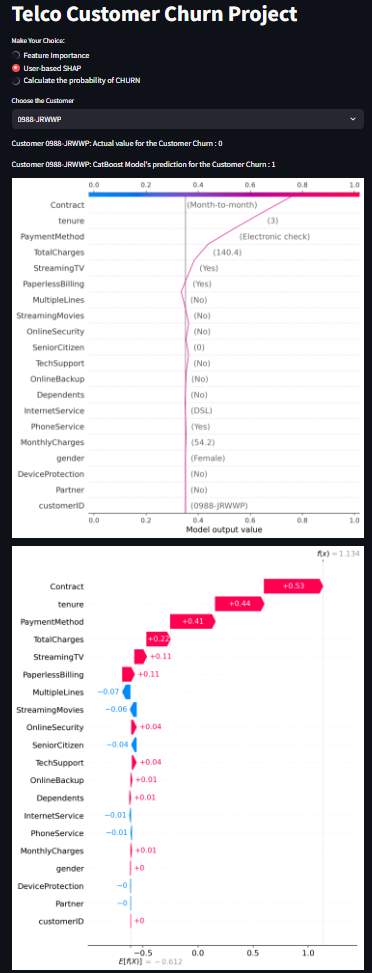

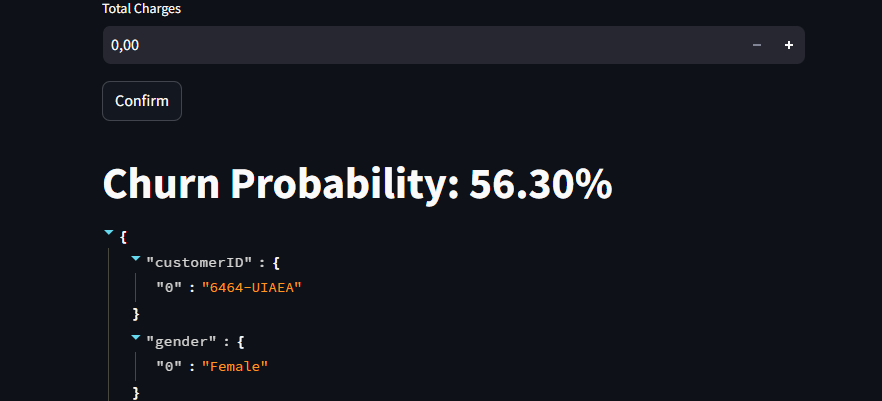